# Publication Figures

This notebook reproduces all the figure from the publication Milovac et al.,"Regional scaling of sea surface temperature with global warming levels in the CMIP6 ensemble". The data for plotting are published on Zenodo (link to be provided)

### Loading libraires:

In [58]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.tri import Triangulation
from matplotlib import rcParams
from sklearn import linear_model
from scipy import stats
from scipy.optimize import curve_fit
import shapefile as shp 
import cartopy.crs as ccrs
import seaborn as sns
import warnings
import os

#Ignore warnings:
warnings.filterwarnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)

### Define functions:

In [59]:
# Read strings from a txt file
def read_txt(fname, ncolumns, dtype):
    fdata   = open(fname)
    flines  = np.array(fdata.readlines())
    data_in = np.empty([len(flines)])
    if dtype == 'string':
        data_in = np.empty([len(flines)], dtype=object)
    for i in np.arange(len(flines)):
        data_in[i]=flines[i].split()[ncolumns-1]      
    return(data_in)
    fdata.close()
    
# Read data from a txt file
def read_data(fname, ncolumns):
    if ncolumns > 1:
        fdata   = open(fname)
        flines  = np.array(fdata.readlines())
        data_in = np.empty([len(flines), ncolumns])
        for i in np.arange(len(flines)):
            data_in[i,:]=flines[i].split()
    else:
        with open(fname) as flist:
            data_in = np.array(flist.readlines())        
    return(data_in)
    fdata.close()
    
def reglist(path2reglist,reglist):
    regions = f'{path2reglist}/{reglist}'
    regions_long  = read_txt(regions, 3, 'string')
    regions_short  = read_txt(regions, 2, 'string')
    regnames = regions_long
    for long,short,i in zip(regions_long,regions_short,np.arange(0,len(regions_long))):
        regnames[i] = f'{long} ({short})'
    return regnames

# Read a mask from the netcdf file
def read_mask(fname, varname):
    f = nc.Dataset(fname)
    var  = f.variables[varname][:]
    return var

# Read a mask from a shape file
def plot_shapefile(shape_file, region, ax):
    sf = shp.Reader(shape_file)
    shape=sf.shapeRecords()[region]
    for k in range(len(shape.shape.parts)):
        k_start = shape.shape.parts[k]
        if k==len(shape.shape.parts)-1:
            k_end = len(shape.shape.points)
        else:
            k_end = shape.shape.parts[k+1]
        x = [k[0] for k in shape.shape.points[k_start:k_end]]
        y = [k[1] for k in shape.shape.points[k_start:k_end]]
        ax.plot(x,y, 'black', linewidth=0.5)


def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))        # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesE = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesS = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesW = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

### Define enviromental variables and paths:

In [60]:
# Define variables
resolution      = 'low_res'
dirname         = 'ipcc_regs'
member_names    = f'model_{resolution}_names.txt'
ref_ntimes      = 51
ystart_to_plot  = 2010
ystart          = int(ystart_to_plot - 1950)
avg_period      = 10
seasons         = ['ANNUAL','DJF','MAM','JJA', 'SON'] 
season_names    = ['ANN','DJF','MAM','JJA','SON']
nseasons        = len(seasons)
ssps            = ['ssp126','ssp245','ssp370','ssp585']
nssps           = len(ssps)

# Define paths
root = '..'
path2data = f'{root}/data/data_txt/'   
path2figs = f'{root}/figures/'  
path2mask = f'{root}/data/masks/'
path2info = f'{root}/data/data_info/'
landsea_mask         = f'{path2mask}/land_sea_mask_025degree_binary.nc4'
shape_file_biomes    = f'{root}/data/polygons/IPCC-reference-regions/ocean-biomes.shp'
shape_file_ipcc      = f'{root}/data/polygons/IPCC-reference-regions/IPCC-WGI-reference-regions-v4.shp'
shape_file_new_ipcc  = f'{root}/Physical-climate-assessment-reference-regions-v4.1/Physical-climate-assessment-reference-regions-v4.1.shp'
shape_file_coastline = f'{root}/data/polygons/coastlines/WORLD_coastline.shp'

if not os.path.exists(path2figs):
    os.makedirs(path2figs)

### Read list of the models to be processed:

In [61]:
member_list = f'{path2info}/{member_names}'
members  = read_txt(member_list, 1, 'string')
nmembers = len(members)

In [62]:
mask_files = {
    'biomes_regs':['ocean-biomes_05mask.nc','sftlf', [0,1,2,3,4,5,6,7,8,9,10],  'biomes_regs', shape_file_biomes],
    'ipcc_regs':['IPCC-WGI-reference-regions-v4_05mask.nc','regionID',[9,20,39,47,48,49,50,51,52,53,54,55,56,57,58], 'ipcc_regs',shape_file_ipcc ],
    'ipcc_new_regs':['IPCC-WGI-reference-regions-v4_ocean-regions-refined_05mask.nc','layer',[48,49,52,53,54,56,57,58,60,62,63], 'ipcc_new_regs', shape_file_new_ipcc],
    'ipcc_new_regs_complete':['IPCC-WGI-reference-regions-v4_ocean-regions-refined_05mask.nc','layer',[9,20,39,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], 'ipcc_new_regs', shape_file_new_ipcc] 
}

mask_files_hires = {
    'biomes_regs':['ocean-biomes_025mask.nc','z', [0,1,2,3,4,5,6,7,8,9,10],  'biomes_regs', shape_file_biomes],
    'ipcc_regs':['IPCC-WGI-reference-regions-v4_025mask.nc','regionID',[9,20,39,47,48,49,50,51,52,53,54,55,56,57,58], 'ipcc_reg',shape_file_ipcc ]
}

# Figures 1 and 4: Masks

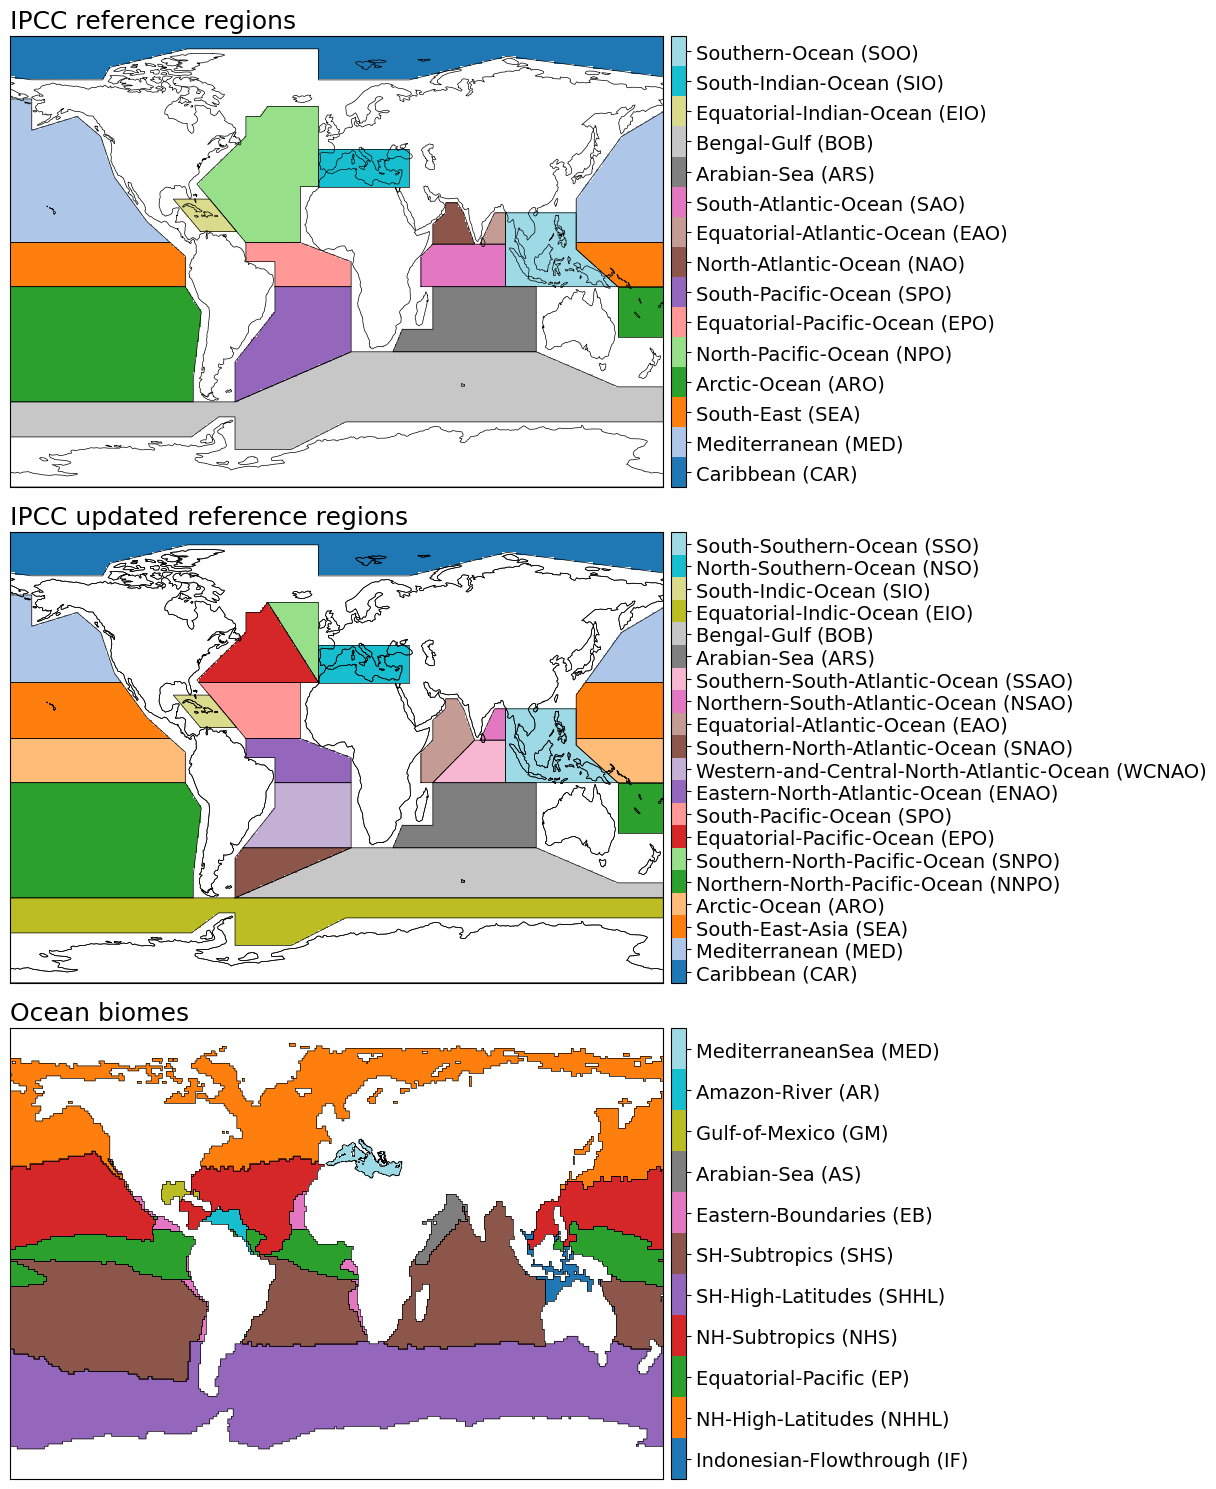

In [63]:
fontsize=14
masks = ['ipcc_regs', 'ipcc_new_regs', 'biomes_regs']
titles = ['IPCC reference regions', 'IPCC updated reference regions', 'Ocean biomes']
    
ipcc_regions = reglist(path2info,'ipcc_regs_names.txt')
ipcc_new_regions = reglist(path2info,'ipcc_new_regs_names.txt')
biomes_regions = reglist(path2info,'biomes_regs_names.txt')

plt.rcParams.update({'font.family':'sans-serif'})
fig, axes = plt.subplots(3,1,sharex=True,figsize=(12,15))
cmap = plt.get_cmap('tab20', 20)
#cmap = 'tab20'
for i in np.arange(len(masks)): 
    maskname = masks[i]
    mask=mask_files[maskname][0]
    varname=mask_files[maskname][1]
    ds=xr.open_dataset(f'{path2mask}/{mask}')
    
    # Set land regions to missing values
    if maskname=='ipcc_regs':    
        ds[varname].data = np.select([ds[varname].data == 9, ds[varname].data == 20, ds[varname].data == 39, ds[varname].data < 47],
                             [59, 60, 61, np.nan], default=ds[varname].data)
        var=ds[varname]
        plot=var.plot(ax=axes[i], cmap = cmap, rasterized=True)  
        plot.colorbar.remove()
        cbar=plt.colorbar(plot, ax=axes[i], ticks=np.linspace(47,61,15), boundaries=np.arange(46.5,62,1), aspect=30, pad=0.01)
        cbar.ax.set_yticklabels(ipcc_regions, fontsize=fontsize)
        cbar_colors = cbar.cmap(np.linspace(0, 1, 15))
        regions = mask_files[maskname][2]
        for reg in regions:
            plot_shapefile(mask_files[maskname][4], reg-1, axes[i])
        for wreg in np.arange(1,127):
            plot_shapefile(shape_file_coastline, wreg-1 , axes[i])
        
    elif maskname=='ipcc_new_regs':     
        ds[varname].data = np.select([ds[varname].data == 9, ds[varname].data == 20, ds[varname].data == 39, ds[varname].data < 47],
                                     [64, 65, 66, np.nan], default=ds[varname].data)
        var=ds[varname]
        plot=var.plot(ax=axes[i], cmap = cmap, rasterized=True) 
        plot.colorbar.remove()
        for wreg in np.arange(1,127):
            plot_shapefile(shape_file_coastline, wreg-1 , axes[i])
        cbar=plt.colorbar(plot, ax=axes[i], ticks=np.linspace(47,66,20), boundaries=np.arange(46.5,67,1), aspect=30, pad=0.01)
        cbar.ax.set_yticklabels(ipcc_new_regions, fontsize=fontsize)
        cbar_colors = cbar.cmap(np.linspace(0, 1, 20))
        regions = mask_files['ipcc_new_regs_complete'][2]
        for reg in regions:
            plot_shapefile(mask_files[maskname][4], reg-1, axes[i])
        for wreg in np.arange(1,127):
            plot_shapefile(shape_file_coastline, wreg-1 , axes[i])
    else:
        var=ds[varname]
        plot=var.plot(ax=axes[i], cmap = cmap, rasterized=True)  
        plot.colorbar.remove()
        cbar=plt.colorbar(plot, ax=axes[i], ticks=np.linspace(0,10,11), boundaries=np.arange(-0.5,11,1), aspect=30, pad=0.01)
        cbar.ax.set_yticklabels(biomes_regions, fontsize=fontsize)
        regions = mask_files[maskname][2]
        for reg in regions:
            plot_shapefile(mask_files[maskname][4], reg-1, axes[i])  
        
    axes[i].set_title('') 
    axes[i].set_title(titles[i], fontsize=18, loc='left')            
    axes[i].set_xticks([]),axes[i].set_yticks([])
    axes[i].set(xlabel=None), axes[i].set(ylabel=None)
    
plt.tight_layout()
plt.savefig(f'{path2figs}/Fig1_4.pdf', bbox_inches='tight')
plt.savefig(f'{path2figs}/Fig1_4.png', bbox_inches='tight', dpi=300)
plt.show()

# Figure 2: GWL plots

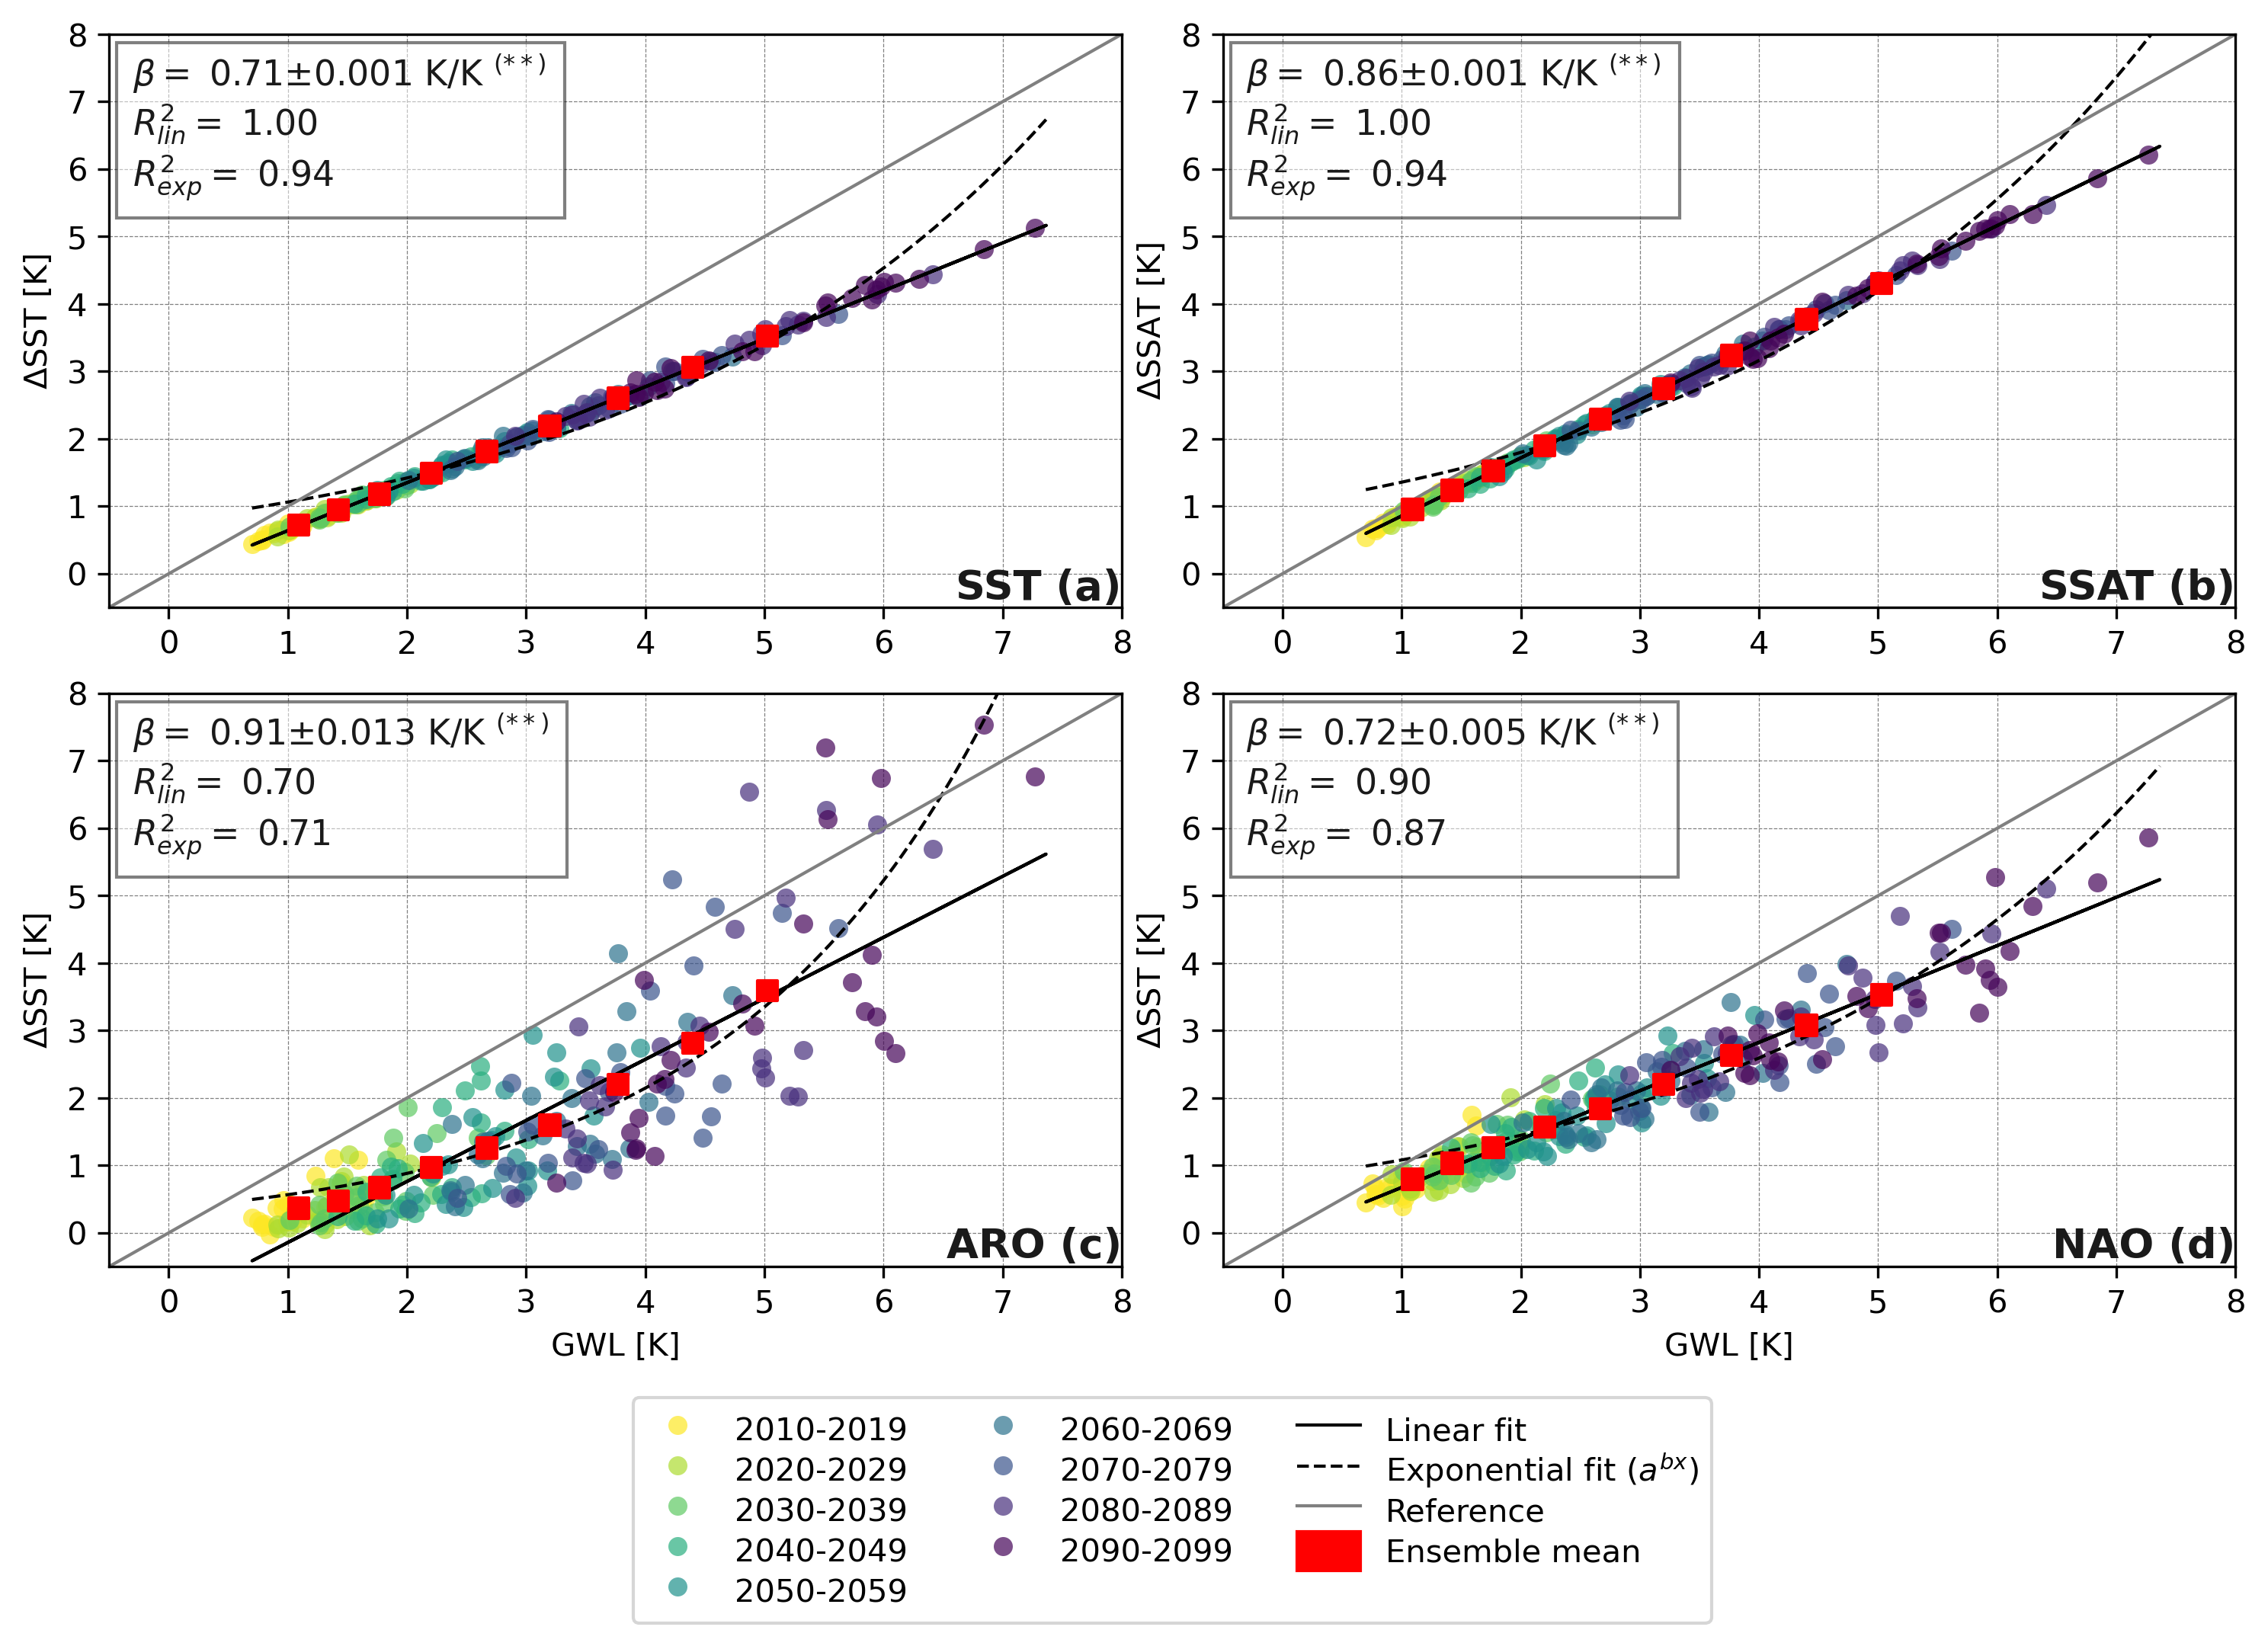

In [64]:
fig, axs = plt.subplots(2,2,figsize=(12,7), dpi=300) 
plt.subplots_adjust(hspace = 0.15, wspace = 0.1)

titles = ['SST (a)', 'SSAT (b)', 'ARO (c)', 'NAO (d)']
varnames = ['SST', 'SSAT', 'SST', 'SST']
ssp = 'ssp585'

# Read reference data
ref_fname = f'{path2data}/{resolution}/global/tas/tas_{ssp}_ANNUAL.csv'
ref_data = read_data(ref_fname, nmembers)

# Define filenames
dirpaths = [f'{resolution}/global/tos/', f'{resolution}/global/stas/',
           f'{resolution}/regional/{dirname}/tos/ANNUAL/', f'{resolution}/regional/{dirname}/tos/ANNUAL/']

filenames = [f'tos_{ssp}_ANNUAL', f'stas_{ssp}_ANNUAL',
             f'tos_{ssp}_reg47_ANNUAL', f'tos_{ssp}_reg51_ANNUAL']

# Define x and y tickmark boundaries                        
xmin, xmax = -0.5, 8
ymin, ymax = -0.5, 8

for i in np.arange(len(filenames)):
    if i < 2:
        j, k = i, 0
    else:
        j, k = i-2, 1
        
    filename, dirpath, title = filenames[i], dirpaths[i], titles[i] 
    
    fname = f'{path2data}/{dirpath}/{filename}.csv'
    data = read_data(fname, nmembers)
    
    robust_fname = f'{path2data}/{dirpath}/ifrobust_{filename}.csv'       
    robustness = read_data(robust_fname, 1)

    plot_timesteps   = np.arange(ystart, data.shape[0], avg_period)
    ensemble_refmean = np.empty([len(plot_timesteps)])
    ensemble_mean    = np.empty([len(plot_timesteps)])           

    colors = cm.get_cmap('viridis_r', data.shape[0]-ystart) 
    
    for l in np.arange(ystart, data.shape[0], avg_period):

        label=str(int(1950+l)) + "-" + str(int(1950+l+avg_period-1))

        # Set x and y tickmark boundaries
        axs[k,j].set_xlim([xmin, xmax])
        axs[k,j].set_ylim([ymin, ymax])

        # Plot data vs. gwl
        axs[k,j].plot(ref_data[l,:], data[l,:], 
                      'o',
                      color=colors(l-ystart),
                      markeredgewidth=0,
                      label=label,
                      alpha=0.7)    

        # Calculate calculate ensemble mean
        index = int((l-ystart)/avg_period)
        ensemble_refmean[index] = np.mean(ref_data[l,:])
        ensemble_mean[index]    = np.mean(data[l,:])  
        
    # Calculate and plot linear fit    
    x = ref_data[ystart::,:].reshape(-1, 1)
    y = data[ystart::,:].reshape(-1, 1)
    lm = linear_model.LinearRegression()
    model = lm.fit(x, y) 
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x[:,0], y[:,0])    
    Beta, R2_lin, std_value = slope, rvalue*rvalue, stderr      
    
    # Plot linear fit
    axs[k,j].plot(x, model.predict(x), '-', color="black", label="Linear fit", linewidth = 1)
    
    # Calculate and plot exponential fit
    def func(x, a, b): return a * np.exp(b * x)
    popt, pcov = curve_fit(func, x[:,0], y[:,0])
    x_fitted = np.linspace(np.min(x[:]), np.max(x[:,0]), 100)
    y_fitted = func(x_fitted, *popt) #a * np.exp(b * x_fitted)
    residuals = y[:,0] - func(x[:,0], *popt)
    res = np.sum(residuals**2)
    tot = np.sum((y[:,0]-np.mean(y[:,0]))**2)
    R2_exp = 1 - (res / tot)
    
    # Plot exponential fit
    axs[k,j].plot(x_fitted, y_fitted, '--', color="black", label="Exponential fit ($a^{bx}$)", linewidth = 1)
    
    # Add titles in the lower right corner             
    axs[k,j].annotate(title, xy=(1, 0), xycoords='axes fraction', fontsize=13, color='k', fontweight = 'bold', 
                     horizontalalignment='right', verticalalignment='bottom')
    
    # Add statistical info in the upper left corner             
    stat_info='$\\beta=$ %4.2f$\pm$%5.3f K/K $^{(**)}$ \n$R^2_{lin}=$ %4.2f \n$R^2_{exp}=$ %4.2f' % (slope, stderr, R2_lin, R2_exp)
    axs[k,j].annotate(stat_info, xy=(0.023, 0.97), xycoords='axes fraction', 
                      fontsize=11, color='k',
                      horizontalalignment='left', verticalalignment='top',
                      bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5})
    
    # Add reference line
    axs[k,j].axline((0, 0), (1, 1), color='grey', linewidth = 1, label="Reference")
    
    # Add ensemble mean to the plot            
    for l in np.arange(ystart, data.shape[0], avg_period):
        index = int((l-ystart)/avg_period)
        
        if float(robustness[l]) == 1.:
            axs[k,j].scatter(ensemble_refmean[index], ensemble_mean[index], 
                             s=40, marker='s',
                             facecolor="red", edgecolor="red",
                             hatch='',zorder=10)
        elif float(robustness[l]) == 0.:
            axs[k,j].scatter(ensemble_refmean[index], ensemble_mean[index], 
                             s=40, marker='s', 
                             facecolor="none", edgecolor="black",
                             hatch=3*'//',zorder=10)                
        else:
            axs[k,j].scatter(ensemble_refmean[index], ensemble_mean[index], 
                             s=40, marker='s', 
                             facecolor="none", edgecolor="black",
                             hatch=6*'x',zorder=10) 
            
    # Add grid lines  
    axs[k,j].grid(color='grey', linestyle='--', linewidth=0.3)
    
    
    # Get Lines and lables for the legend 
    h, l = axs[k,j].get_legend_handles_labels()
    handles = h+[plt.plot([],marker="",  ls="")[0]]
    handles.append(mpatches.Patch(facecolor='red',  edgecolor='red'))
    labels = l +  ["", "Ensemble mean"]
    
    # Rearange the labele for legend to look better
    handles[9]=[plt.plot([],marker="",  ls="")[0]]
    labels[9]=""
    handles[10:len(h)+1]=h[9:len(h)]
    labels[10:len(h)+1]=l[9:len(h)]


    # Add legend
    if k==1 and j==1:
        axs[k,j].legend(handles, labels, 
                        fontsize='medium', loc="lower center", 
                        bbox_to_anchor=(-0.05, -0.65), ncol=3,
                        handleheight=1.5, labelspacing=0.05, 
                        title_fontsize = 12) 
        
    # Add x axis title   
    if k==1:
        axs[k,j].set_xlabel('GWL [K]')
    axs[k,j].set_ylabel(f'$\\Delta${varnames[i]} [K]')
     
# Saving the figure
plt.savefig(f'{path2figs}/Fig_2.pdf', bbox_inches='tight')
plt.savefig(f'{path2figs}/Fig_2.png', bbox_inches='tight')
plt.show()

# Figure 3: Spatial maps

In [65]:
def spatial_plot(resolution, path2data, varname = 'tos'):    
    
    # Define lats and lons
    lat = np.linspace(-89.5,90,180)
    lon = np.linspace(-179.5,180,360)
    XX, YY = np.meshgrid(lon, lat)     
    
    if not os.path.exists(path2figs):
        os.makedirs(path2figs)
    
    # Define masks that will be applied
    masknames = ['ipcc_regs', 'biomes_regs', '']
    titles = ['IPCC regions', 'Biomes regions', 'Gridded']
    
    levels = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.2,1.4,1.7,2.,3.,4.,5.,7.]
    colors1 = plt.cm.jet(np.linspace(0, 0.9, 128))[0::10]
    colors2 = plt.cm.hot_r(np.linspace(-0.1, 7, 128))
    colors = np.vstack((colors1[0:11],colors2[13:len(levels)+1]))
    colormap, norm = mcolors.from_levels_and_colors(levels, colors)
    
    # Define figure characteristics (size, blanks between the subplots)
    fig, axes = plt.subplots(len(masks), len(seasons), figsize=(len(seasons)*4.5,len(masks)*3))
    plt.subplots_adjust(hspace = 0.04, wspace = 0.03)
    
    # Iterating over the seasons
    for i in np.arange(len(seasons)):
        season=seasons[i]
        
        # Iterating over the masks
        for j in np.arange(len(masks)):
                
            if j<2:      
                
                maskname    = masknames[j]
                mask_file   = mask_files[maskname][0]
                maskvar     = mask_files[maskname][1]
                mask_values = mask_files[maskname][2]
                dirname     = mask_files[maskname][3]                
                shapefile   = mask_files[maskname][4]
                
                            
                ds=xr.open_dataset(f'{path2mask}/{mask}')          

                # Define mask variables and read mask
                ds_control=xr.open_dataset(f'{path2mask}/{mask_file}') # file that will not be changed for masking
                ds=xr.open_dataset(f'{path2mask}/{mask_file}')  
                
                # Read data
                datadir=f'{path2data}/{resolution}/regional/{dirname}/{varname}/{season}'
                fname=f'{datadir}/Beta_{varname}_{season}.csv'                
                datain=read_data(fname, 4)  
                
                # Masking continental areas and filling the regional values
                ds[maskvar].data[np.where(ds[maskvar].data<47)] = np.nan
                for k in np.arange(len(mask_values)):
                    mask_value=mask_values[k]  
                    ds[maskvar].data[np.where(ds_control[maskvar].data == mask_value)] = datain[k,3]
                    masked_data=ds[maskvar].data  
                
                # Generating the plot
                plot = ds[maskvar].plot(ax=axes[j,i], cmap=colormap, norm=norm, alpha=1, rasterized=True) 
                
                # Add regional borders
                for reg in mask_values:
                    plot_shapefile(shapefile, reg-1, axes[j,i]) 
                    
                # Remove automatically generated colorbar
                plot.colorbar.remove() 
                
            else:
                
                # Reading and plotting Beta
                datadir=f'{path2data}/{resolution}/spatial/{varname}/' 
                fname=f'{datadir}/Beta_{varname}_{season}.csv'
                data = read_data(fname, 360)                         
                plot = axes[j,i].pcolormesh(XX, YY, data, cmap=colormap, norm=norm, alpha=1, rasterized=True)
                
                # Hatching areas with sea-ice
                ds = xr.open_dataset(f'{root}/data/data_raw/low_res/seaice/CMIP6_ssp585_siconc_{season}.nc')
                siconc_masked = np.ma.masked_less(ds.siconc.data, 5)
                if np.nanmax(np.abs(siconc_masked))>0.0:
                    plt.rcParams.update({'hatch.color': 'grey'})
                    axes[j,i].contourf(XX, YY, siconc_masked, hatches=['/////'], colors='grey', alpha=0.3, zorder=2)
                
                # Hatching nonsignificant area
                pvalue_datapath = f'{datadir}/p_value_{varname}_{season}.csv'
                p_value = read_data(pvalue_datapath, 360)
                data_significant = np.ma.masked_less_equal(p_value, 0.01)
                if np.nanmax(np.abs(data_significant))>0.0:
                    plt.rcParams.update({'hatch.color': 'black'})                    
                    axes[j,i].contourf(XX, YY, data_significant, hatches=['xxxxx'], colors=None, alpha=0., zorder=4)
                
                # Plotting regional borders
                for reg in mask_values:
                    plot_shapefile(shapefile, reg-1, axes[j,i])
                
            # Setting axis names
            axes[j,i].title.set_size(10)
            axes[j,i].set_xticks([]), axes[j,i].set_yticks([])   
            
            # Tide tickmarks
            if j==0:
                axes[j,i].set_title(f'{season}', fontsize=15)
            else:
                axes[j,i].set_title('')
                
            if i==0:
                axes[j,i].set_xlabel(xlabel=None), 
                axes[j,i].set_ylabel(ylabel=titles[j], fontsize=15)
            else: 
                axes[j,i].set_xlabel(xlabel=None) 
                axes[j,i].set_ylabel(ylabel=None)              
    
    # Set colorbar
    cbar = fig.colorbar(plot, ax=axes.ravel().tolist(), shrink=0.8, 
                        aspect=80, pad=0.01, extend='neither',
                        location='bottom') 
    cbar.set_label('$\\beta$ [K/K]', labelpad=0, rotation=0, fontsize=15)
    cbar.ax.tick_params(labelsize='xx-large')
    
    # Save figure
    plt.savefig(f'{path2figs}/Fig_3_{resolution}_{varname}.pdf', bbox_inches='tight')
    plt.savefig(f'{path2figs}/Fig_3_{resolution}_{varname}.png', bbox_inches='tight')
    plt.show()

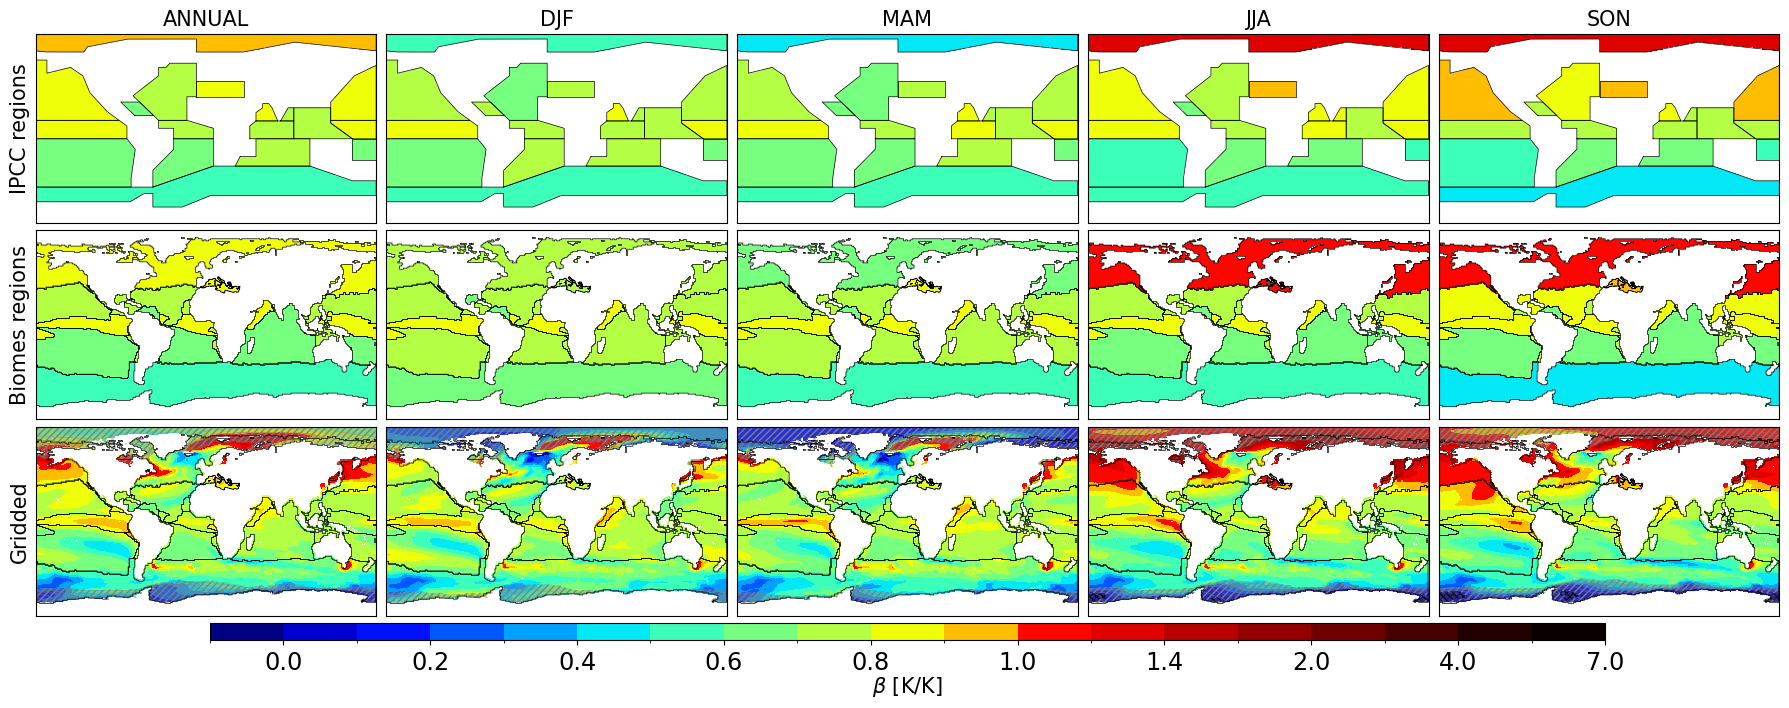

In [66]:
data=spatial_plot(resolution, path2data, varname = 'tos')

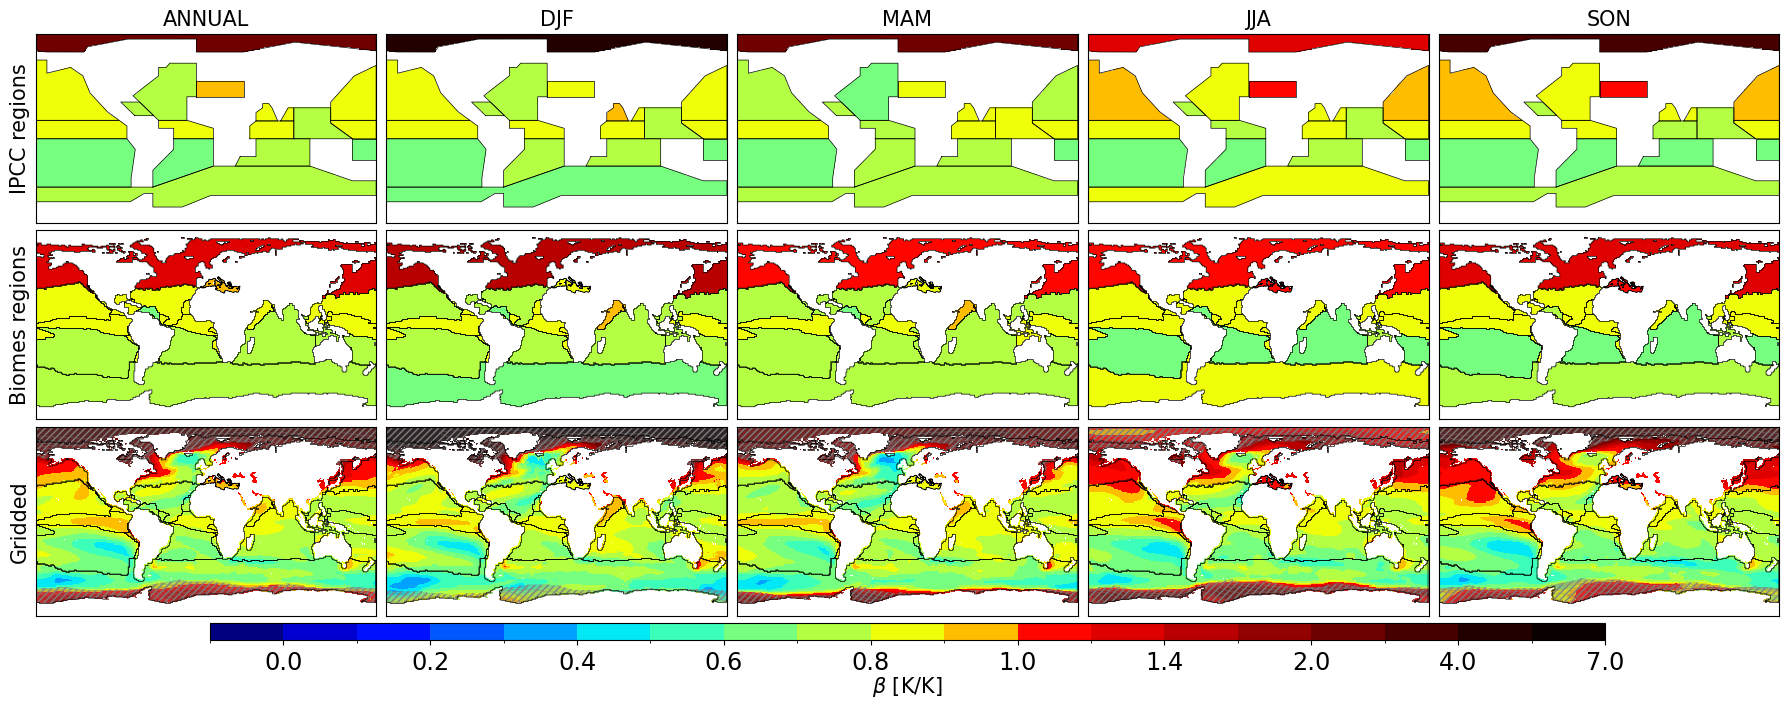

In [67]:
data=spatial_plot(resolution, path2data, varname = 'stas')

# Figures 5 and 15: Bar plots for the default and new IPCC reference regions

In [68]:
def cal_mean_std(varname, maskname, seasons=['ANNUAL','DJF','MAM','JJA', 'SON']):    
    maskfile   = mask_files[maskname][0]
    maskvar    = mask_files[maskname][1]
    if maskname == 'ipcc_regs':
        regions = [48,51,53,54,56,58]
    elif maskname == 'ipcc_new_regs':
        regions  = [48,49,52,53,54,56,57,58,60,62,63]
    shape_file   =  mask_files[maskname][4]
    maskara      = read_mask(f'{root}/data/masks/{maskfile}', maskvar)[:,:]    
    std_spatial  = np.empty((len(regions),len(seasons)),dtype=float)
    mean_spatial = np.empty((len(regions),len(seasons)),dtype=float)
    
    for j, r in zip(np.arange(len(regions)),regions):  
        region = np.ma.masked_not_equal(maskara, r)
        region[~region.mask] = 1
        for i, season in zip(np.arange(len(seasons)),seasons):  
            beta_file = f'{path2data}/low_res/spatial/{varname}/Beta_{varname}_{season}.csv'
            beta = read_data(beta_file,360)
            beta = beta*region
            
            std_spatial[j,i] = np.nanstd(beta)
            mean_spatial[j,i] = np.nanmean(beta)
            
    return std_spatial, mean_spatial
    

def barplot(varname, figname):
    #sns.set() 
    sns.set(style="darkgrid", palette="pastel")
    
    regions=[48,51,53,54,56,58]
    new_regions=[48,49,52,53,54,56,57,58,60,62,63]
    new_regnames = ['NPO','NNPO','SNPO','NAO','ENAO','WCNAO','SNAO','SAO','SSAO','NSAO','ARS','ARS_new','EIO','EIO_new','SOO','NSO','SSO']
    
    std_spatial_new, mean_spatial_new = cal_mean_std(varname, 'ipcc_new_regs')
    std_spatial, mean_spatial = cal_mean_std(varname, 'ipcc_regs')
    
    spatial_std = np.empty((len(regions)+len(new_regions),len(seasons)),dtype=float)
    spatial_mean = np.empty((len(regions)+len(new_regions),len(seasons)),dtype=float)

    spatial_std[0,:]=std_spatial[0,:]
    spatial_std[1,:]=std_spatial_new[0,:]
    spatial_std[2,:]=std_spatial_new[1,:]
    spatial_std[3,:]=std_spatial[1,:]
    spatial_std[4,:]=std_spatial_new[2,:]
    spatial_std[5,:]=std_spatial_new[3,:]
    spatial_std[6,:]=std_spatial_new[4,:]
    spatial_std[7,:]=std_spatial[2,:]
    spatial_std[8,:]=std_spatial_new[5,:]
    spatial_std[9,:]=std_spatial_new[6,:]
    spatial_std[10,:]=std_spatial[3,:]
    spatial_std[11,:]=std_spatial_new[7,:]
    spatial_std[12,:]=std_spatial[4,:]
    spatial_std[13,:]=std_spatial_new[8,:]
    spatial_std[14,:]=std_spatial[5,:]
    spatial_std[15,:]=std_spatial_new[9,:]
    spatial_std[16,:]=std_spatial_new[10,:]

    spatial_mean[0,:]=mean_spatial[0,:]
    spatial_mean[1,:]=mean_spatial_new[0,:]
    spatial_mean[2,:]=mean_spatial_new[1,:]
    spatial_mean[3,:]=mean_spatial[1,:]
    spatial_mean[4,:]=mean_spatial_new[2,:]
    spatial_mean[5,:]=mean_spatial_new[3,:]
    spatial_mean[6,:]=mean_spatial_new[4,:]
    spatial_mean[7,:]=mean_spatial[2,:]
    spatial_mean[8,:]=mean_spatial_new[5,:]
    spatial_mean[9,:]=mean_spatial_new[6,:]
    spatial_mean[10,:]=mean_spatial[3,:]
    spatial_mean[11,:]=mean_spatial_new[7,:]
    spatial_mean[12,:]=mean_spatial[4,:]
    spatial_mean[13,:]=mean_spatial_new[8,:]
    spatial_mean[14,:]=mean_spatial[5,:]
    spatial_mean[15,:]=mean_spatial_new[9,:]
    spatial_mean[16,:]=mean_spatial_new[10,:]
    
    indices = {
        '48': [[0,1,2]], 
        '51': [[3,4,5,6]],
        '53': [[7,8,9]],
        '54': [[10,11]],
        '56': [[12,13]],
        '58': [[14,15,16]],
    }     
    
    xdeltas = [-0.1,0.1,0.2,0.3]
    fig, axs = plt.subplots(3,2,figsize=(12,7), dpi=300)

    colors = ['k','orange','purple','green']

    if varname=='tos':
        ymins  = [0.4,0.3,0.4,0.6,0.6,0.0]
        ymaxs  = [0.9,0.9,1.3,0.9,0.9,1.6]
    elif varname=='stas':
        ymins  = [0.4,0.5,0.4,0.7,0.7,0.2]
        ymaxs  = [0.9,1.5,1.3,0.9,0.9,3.2]

    for i, region in zip(np.arange(len(regions)+1),regions):
        inds = indices[f'{region}'][0]
        if i>2:
            ix,iy=i-3,1
        else:
            ix,iy=i,0
            
        for j, ind in zip(np.arange(len(inds)),inds):
            axs[ix,iy].errorbar(np.arange(xdeltas[j],len(spatial_mean[ind,:])+xdeltas[j]), 
                               spatial_mean[ind,:], yerr=spatial_std[ind,:], fmt='o', 
                               color=colors[j], ecolor=colors[j], capsize=4, label=new_regnames[ind])        
        
            axs[ix, iy].legend(ncol=4,fontsize='x-small', markerscale=0.6)  
            axs[ix, iy].set_ylim(ymins[i], ymaxs[i])
            
            if iy==0:
                axs[ix, iy].set_ylabel('$\\beta$ [K/K]')
                
            if ix==2:
                axs[ix, iy].set_xticks(np.arange(len(spatial_mean[0, :])), seasons)
            else:
                axs[ix, iy].set_xticks(np.arange(len(spatial_mean[0, :])),'')

    # Saving the figure
    plt.savefig(f'{path2figs}/{figname}_{varname}.pdf', bbox_inches='tight')
    plt.savefig(f'{path2figs}/{figname}_{varname}.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()    
    sns.reset_orig()

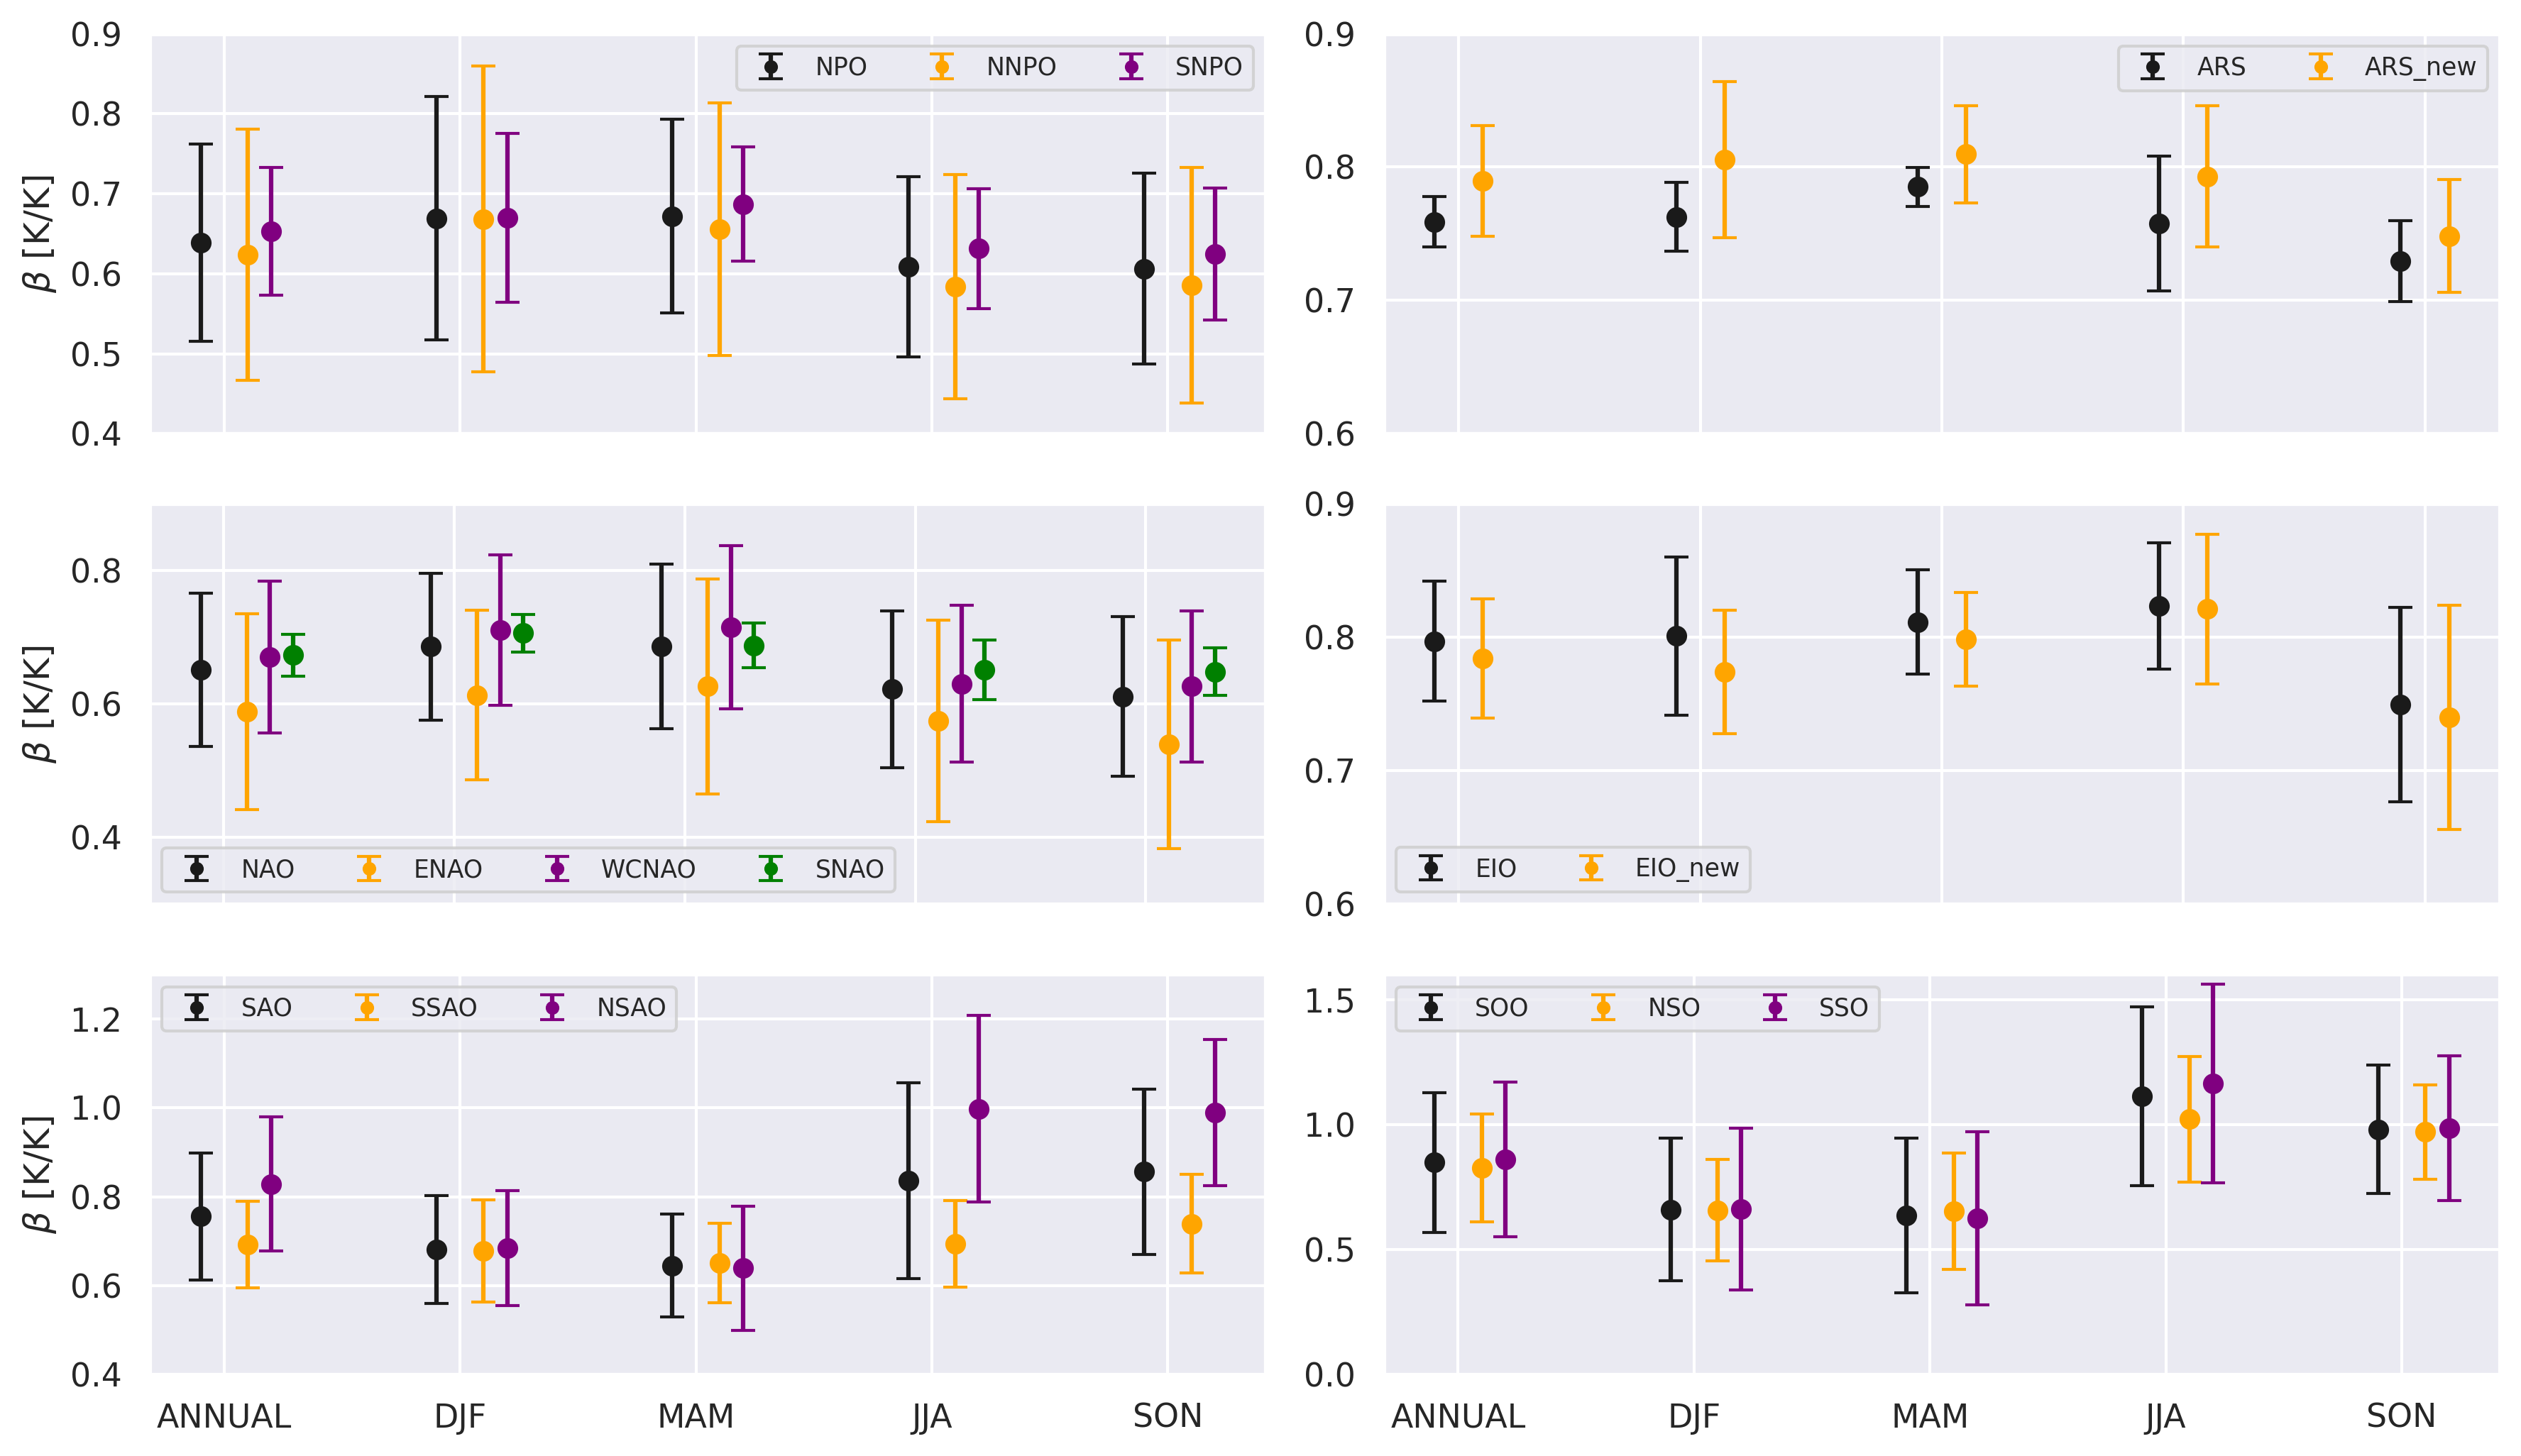

In [69]:
barplot('tos','Fig_5')

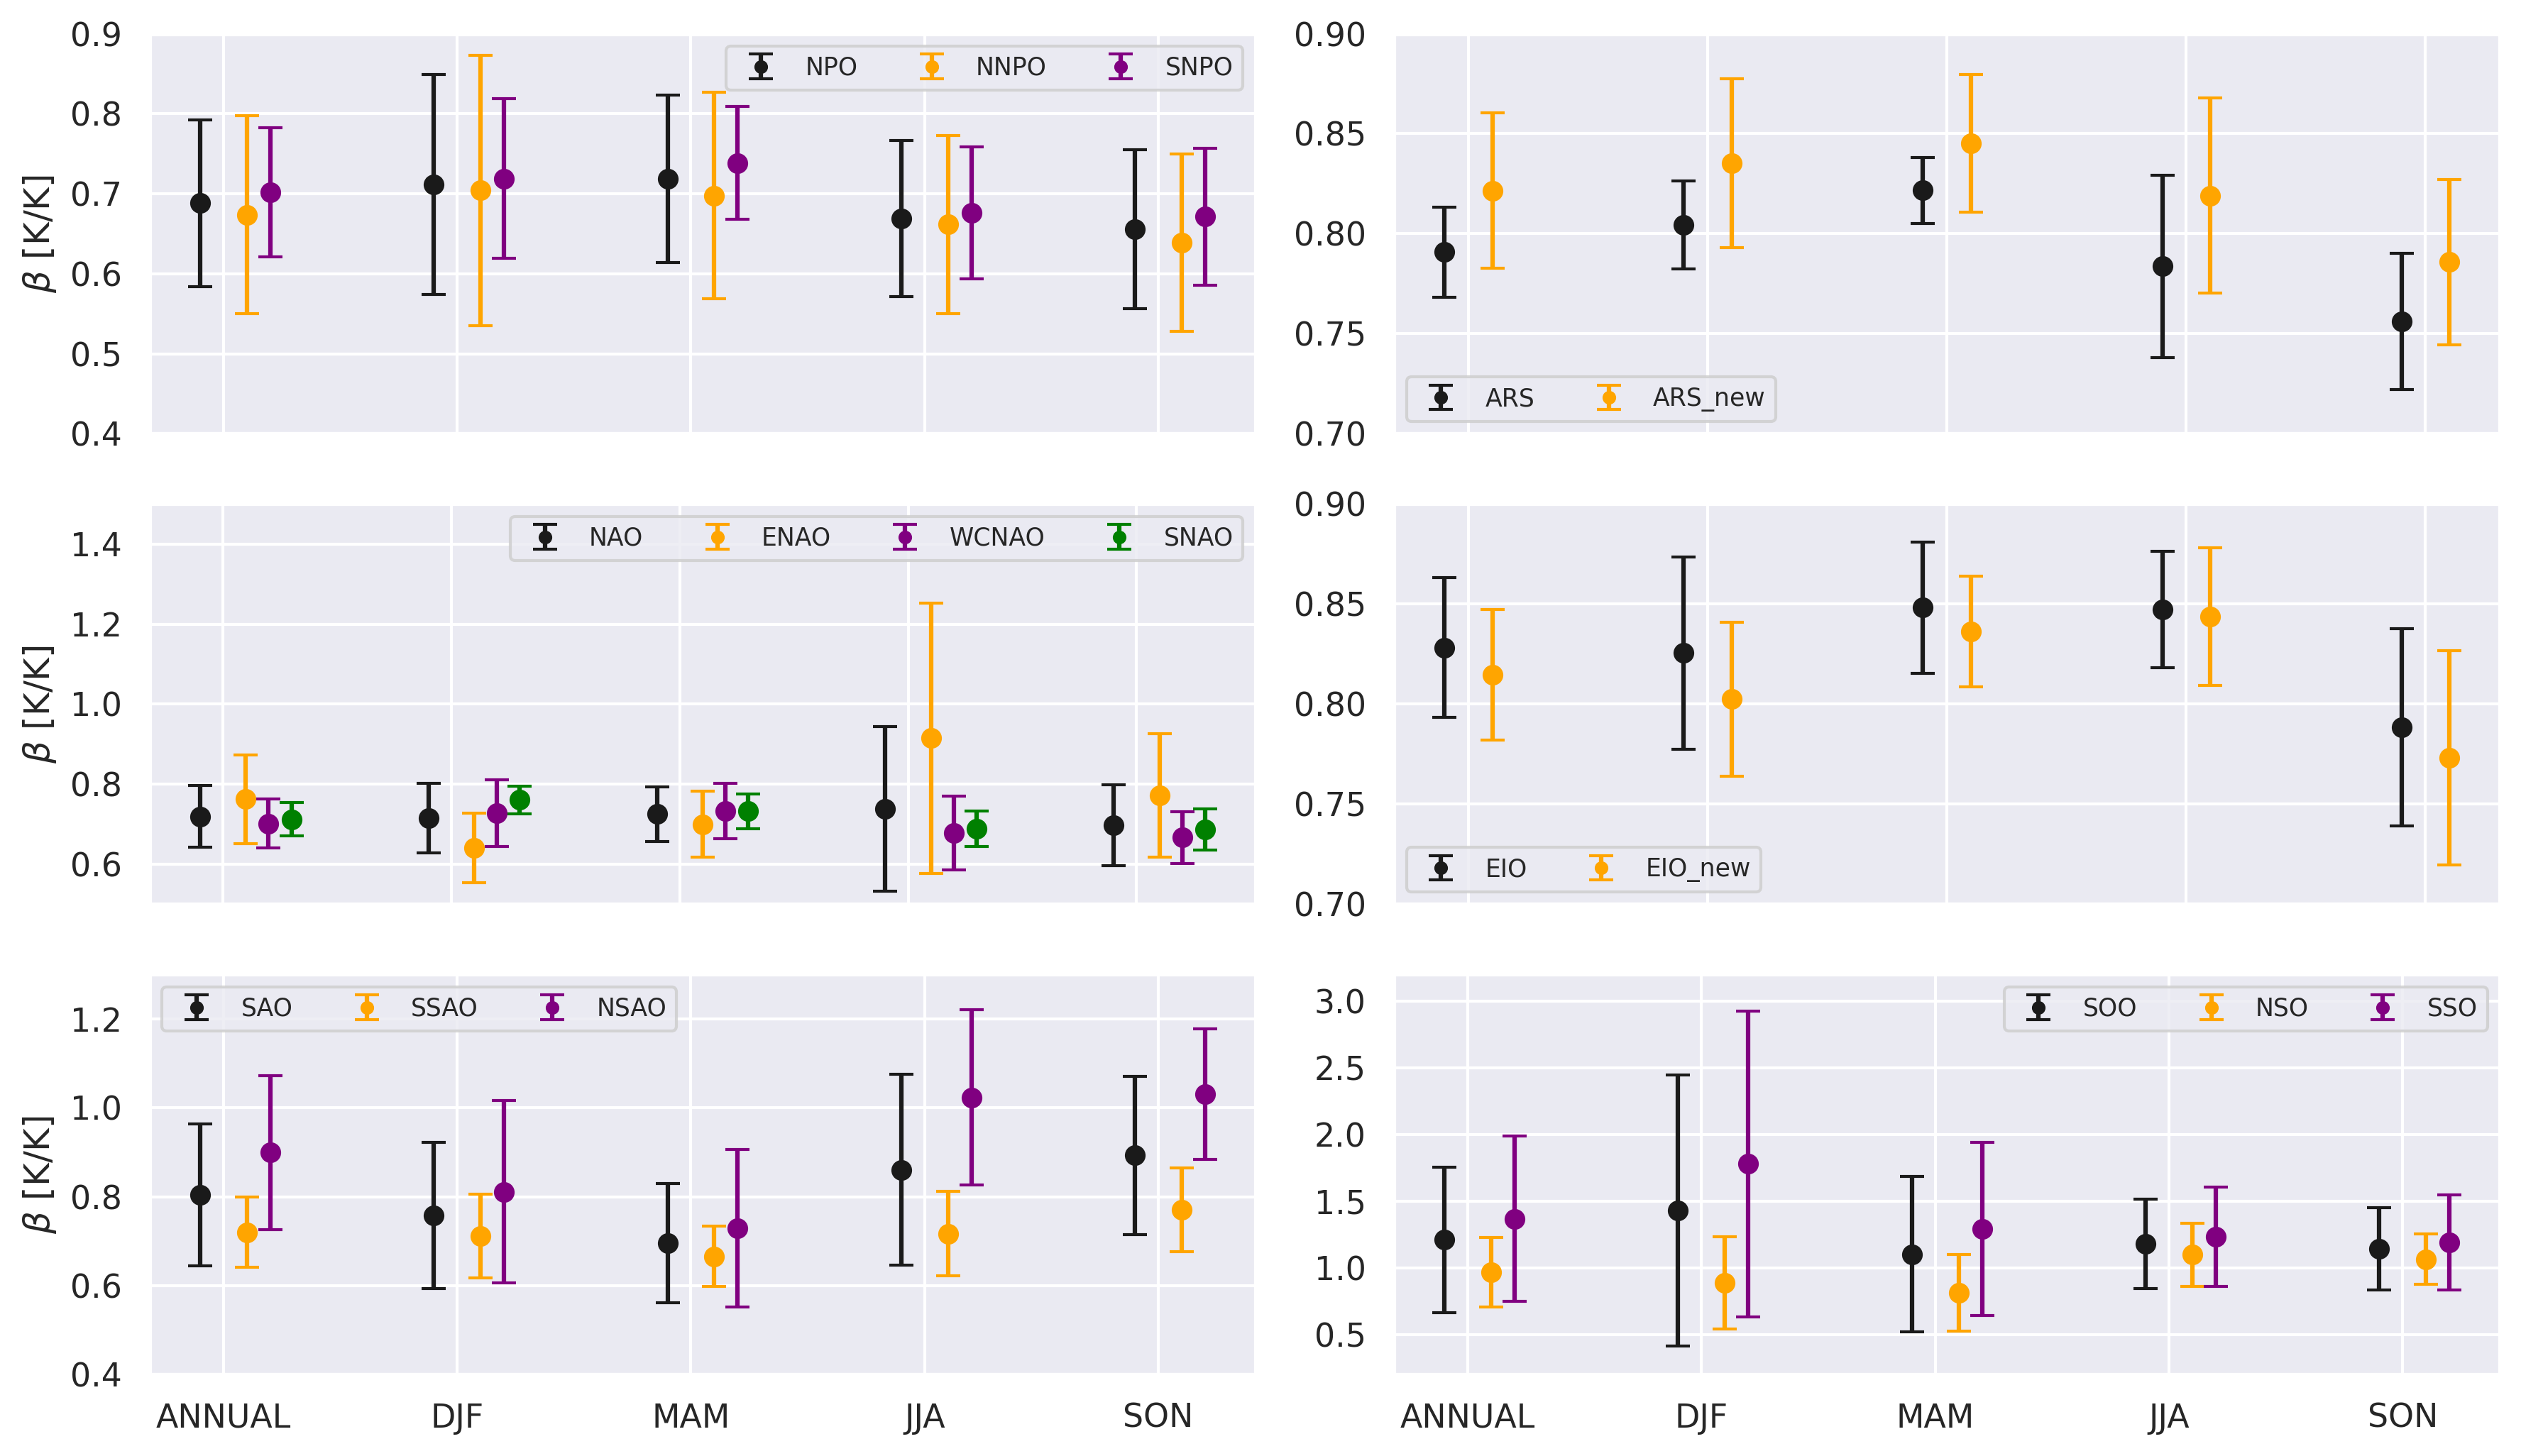

In [70]:
barplot('stas','Fig_15')

# Figure 6: Spatial maps for the high resolution model

In [71]:
def plot_diff(path2data, varname, gcms, seasons, maskname, outname_string):
    
    ssp='ssp585'
    
    maskfile   = mask_files_hires[maskname][0]    
    regions    = mask_files_hires[maskname][2]
    shape_file = mask_files_hires[maskname][4]
    ds=xr.open_dataset(f'{path2mask}/{maskfile}')
        
    projection = ccrs.PlateCarree()
    fontsize   = 15
    
    lat    = np.linspace(-90,90,721)
    lon    = np.linspace(-179.75,180,1440)
    XX, YY = np.meshgrid(lon, lat)
    
    fig, axes = plt.subplots(len(seasons), len(gcms)+1, figsize=((len(gcms)+1)*4,(len(seasons))*1.8),
                            subplot_kw=dict(projection=projection))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)  
    
    levels = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.2,1.4,1.7,2.,3.,4.,5.,7.]
    colors1 = plt.cm.jet(np.linspace(0, 0.9, 128))[0::10]
    colors2 = plt.cm.hot_r(np.linspace(-0.1, 7, 128))
    colors = np.vstack((colors1[0:11],colors2[13:len(levels)+1]))
    cmap, norm = mcolors.from_levels_and_colors(levels, colors)
    
    cmap_delta = plt.cm.get_cmap('coolwarm', len(np.arange(-1,1,0.1)) )
    
    # Reading land sea mask
    maskfile = xr.open_dataset(landsea_mask)
    landsea=maskfile.sftlf[0,:,:].data
    landsea_masked = np.ma.masked_greater(landsea, 0)+1
    
    for i, season in zip(np.arange(len(seasons)),seasons):     
        
        for j, gcm in zip(np.arange(len(gcms)),gcms):            
            print(f'Reading data for gcm {gcm} and season {season}')       

            # Read and plot beta
            beta_file = f'{path2data}/high_res/spatial/{gcm}/{varname}/{season}/Beta_{varname}_{season}.csv'           
            beta = read_data(beta_file,1440)*landsea_masked
            plot = axes[i,j].pcolormesh(XX, YY, beta, alpha=1.,
                                        cmap=cmap, norm=norm, rasterized=True)            
                    
            # Read and hatch areas with sea-ice
            ds = xr.open_dataset(f'{root}/data/data_raw/high_res/seaice/siconc_{gcm}_{ssp}_{season}.nc')
            siconc_masked = np.ma.masked_less(ds.siconc[0,:,:].data , 5)
            # Save data for calculating differences later on
            if gcm=='CNRM-CM6-1' or gcm=='MPI-ESM1-2-LR': 
                beta_lr=beta
                siconc_lr=siconc_masked
                if gcm=='CNRM-CM6-1':
                    gcm_name = 'CNRM-CM6-1-LR'
                patern='//////'
            else:
                beta_hr=beta  
                siconc_hr=siconc_masked
                gcm_name = gcm
                patern='\\\\\\'
                
            plt.rcParams.update({'hatch.color': 'grey'})
            axes[i,j].contourf(XX, YY, siconc_masked, hatches=[patern], colors='grey', alpha=0.3, zorder=2)
            
            # Read and hatch insignifcant areas (p_
            pvalue_file = f'{path2data}/high_res/spatial/{gcm}/{varname}/{season}/p_value_{varname}_{season}.csv'
            pvalue = read_data(pvalue_file,1440)*landsea_masked
            pvalue_masked = np.ma.masked_less_equal(pvalue, 0.01)
            plt.rcParams.update({'hatch.color': 'black'})
            axes[i,j].contourf(XX, YY, pvalue_masked, hatches=['xxxxxxx'], colors='none', alpha=0.0, zorder=4) 
            
            # Plot borders of the biomes
            for reg in regions:
                    plot_shapefile(shape_file, reg-1, axes[i,j])                  
                    
            # Tide tickmarks
            axes[i,j].set_yticks([])
            axes[i,j].set_xticks([])                     
            if i==0:
                axes[i,j].set_title(gcm_name, fontsize=fontsize)
            else:
                axes[i,j].set_title('')
                
            if j==0:
                axes[i,j].set_xlabel(xlabel=None), 
                axes[i,j].set_ylabel(season, fontsize=0.85*fontsize)
            else: 
                axes[i,j].set_xlabel(xlabel=None) 
                axes[i,j].set_ylabel(ylabel=None)   
                

        # Plot the difference
        j = len(gcms)  
        delta = beta_lr-beta_hr    
        dplot = axes[i,j].pcolormesh(XX, YY, delta, alpha=1.,
                                   vmin=-1, vmax=1, cmap=cmap_delta, rasterized=True)   
        
        # Hatchg sea-ice
        plt.rcParams.update({'hatch.color': 'grey'})
        axes[i,j].contourf(XX, YY, siconc_lr, hatches=['//////'], colors='grey', alpha=0.1, zorder=3)
        axes[i,j].contourf(XX, YY, siconc_hr, hatches=['\\\\\\'], colors='grey', alpha=0.1, zorder=4)

        # Plot regional borders
        for reg in regions:
                    plot_shapefile(shape_file, reg-1, axes[i,j])        

        # Remove the tickmarks
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks([])
        
        # Adding title for the y axis
        if i==0:
            #axes[i,j].set_ylabel('$\\Delta$($\\beta_{LR},\\beta_{HR}$)', fontsize=0.65*fontsize)
            axes[i,j].set_title('$\\Delta$($\\beta_{LR},\\beta_{HR}$)', fontsize=fontsize)

    # Add colorbar 1 (colored)
    cbar = fig.colorbar(plot, ax=axes[0:3,:].ravel().tolist(), 
                         location='right', extend='neither', 
                         pad=0.02, aspect=50, shrink=0.8)
    cbar.set_label('$\\beta$ [K/K]', rotation=90, fontsize=fontsize)
    cbar.ax.tick_params(labelsize='large')
    
    # Add colorbar 2 (blue-red)
    cbar = fig.colorbar(dplot, ax=axes[3:len(seasons)+1,:].ravel().tolist(), 
                    location='right', extend='both', 
                    pad=0.02, aspect=30, shrink=0.8)
    cbar.ax.tick_params(labelsize='large')
    cbar.set_label('$\\Delta$($\\beta$) [K/K]', rotation=90, fontsize=fontsize)

    # Save figure
    plt.savefig(f'{path2figs}/Fig_6_{outname_string}.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'{path2figs}/Fig_6_{outname_string}.pdf', bbox_inches='tight')
    plt.show()

Reading data for gcm CNRM-CM6-1 and season ANNUAL
Reading data for gcm CNRM-CM6-1-HR and season ANNUAL
Reading data for gcm CNRM-CM6-1 and season DJF
Reading data for gcm CNRM-CM6-1-HR and season DJF
Reading data for gcm CNRM-CM6-1 and season MAM
Reading data for gcm CNRM-CM6-1-HR and season MAM
Reading data for gcm CNRM-CM6-1 and season JJA
Reading data for gcm CNRM-CM6-1-HR and season JJA
Reading data for gcm CNRM-CM6-1 and season SON
Reading data for gcm CNRM-CM6-1-HR and season SON


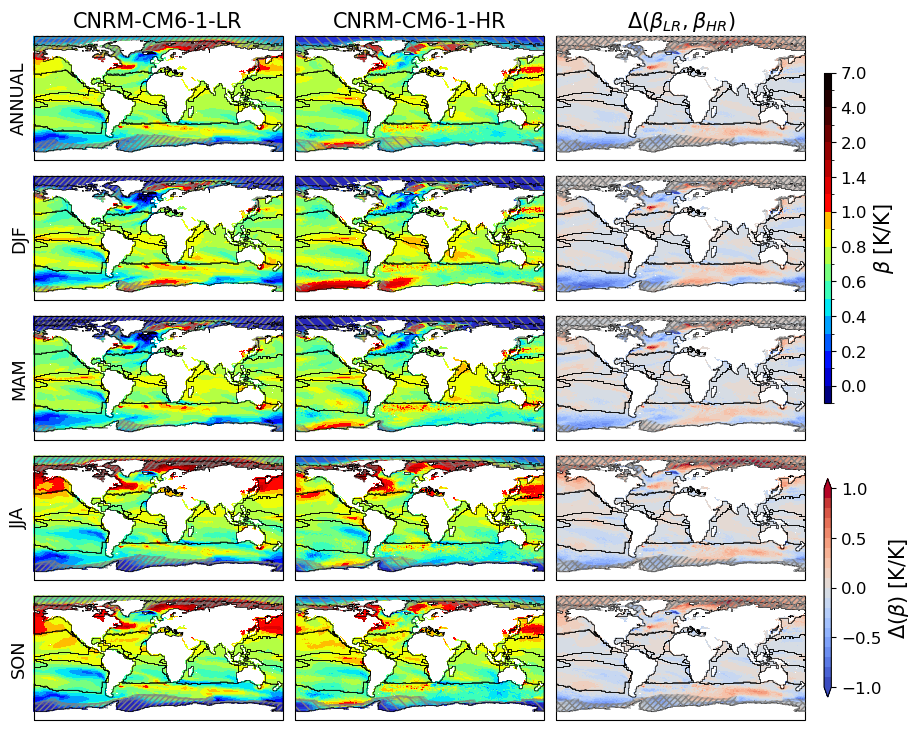

In [72]:
varname = 'tos'
gcms = ['CNRM-CM6-1','CNRM-CM6-1-HR'] 
plot_diff(path2data, varname, gcms, seasons, 'biomes_regs', 'CNRM')

# Figure 7, 8, 9 and 14: Heat map of spatial correlations and spatial maps of beta per region

In [73]:
def plot_regional_delta(path2data, varname, r, gcms, maskname='biomes_regs', ssp='ssp585', fig_xsize=2.5, 
                        fig_ysize=2, vmin=0.325, vmax=1.425, dmax=0.5, figname='', save_fig=True):   
    
      
    maskfile   = mask_files_hires[maskname][0]
    maskvar    = mask_files_hires[maskname][1]
    regions    = mask_files_hires[maskname][2]    
    shape_file = mask_files_hires[maskname][4]
    
    # Define masking 
    if maskname=='ipcc_regs': 
        reg_number=r-1
    else:
        reg_number=r
       
    projection = ccrs.PlateCarree() 
    fontsize=25
    dmax = dmax
    dmin = -dmax
    
    # Define grid
    lat = np.linspace(-90,90,721)
    lon = np.linspace(-179.75,180,1440)
    XX, YY = np.meshgrid(lon, lat)  
    
    # Define figure characteristics
    fig, axs = plt.subplots(len(gcms)+1, len(seasons),
                            figsize=(fig_xsize*len(seasons),fig_ysize*(len(gcms)+1)),
                            subplot_kw=dict(projection=projection))        
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
        
    if maskname=='biomes_regs':
        maskara = read_mask(f'{path2mask}/{maskfile}', maskvar)[0,:,:]
    else:
        maskara = read_mask(f'{path2mask}/{maskfile}', maskvar)[:,:]
        
        
    # Define levels and colormap
    levels = np.arange(vmin,vmax+0.1, 0.1)
    colors1 = plt.cm.jet(np.linspace(0, 0.9, 128))[0::15] #15 10
    colors2 = plt.cm.hot_r(np.linspace(vmin, vmax, 128))[0::7] # 7 4
    colors = np.vstack((colors1[0:len(np.arange(vmin,1,0.1))],
                        colors2[(len(np.arange(vmin,1,0.1)+1)):(len(levels)-1)]))
    cmap = cm.get_cmap('jet', len(np.arange(vmin,vmax,0.1)) )
    cmap_delta = cm.get_cmap('coolwarm', len(np.arange(dmin,dmax,0.1)) )
    region = np.ma.masked_not_equal(maskara, r)
    region[~region.mask] = 1
    
    # Allocate arrays to calculate correlation and pvalue
    pcorr  = np.empty(len(seasons),dtype=float)
    pvalue = np.empty(len(seasons),dtype=float)
    for i, season in zip(np.arange(len(seasons)),seasons):     
        for j, gcm in zip(np.arange(len(gcms)),gcms): 

            beta_file = f'{path2data}/high_res/spatial/{gcm}/{varname}/{season}/Beta_{varname}_{season}.csv'
            beta = read_data(beta_file,1440)    
            
            # Mask data
            beta = beta*region
                
            if gcm=='CNRM-CM6-1' or gcm=='MPI-ESM1-2-LR': 
                beta_lr=beta
            else:
                beta_hr=beta 
        
            index = np.argwhere(~np.isnan(beta))
            xmin, xmax = np.nanmin(index[:,0]), np.nanmax(index[:,0]) 
            ymin, ymax = np.nanmin(index[:,1]), np.nanmax(index[:,1])
            
            if r==9:
                xmin, xmax = 360, np.nanmax(index[:,0])

            plot = axs[j,i].pcolormesh(XX[xmin:xmax,ymin:ymax], YY[xmin:xmax,ymin:ymax], 
                                       beta[xmin:xmax,ymin:ymax], 
                                       cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)   
            

            ds = xr.open_dataset(f'{root}/data/data_raw/high_res/seaice/siconc_{gcm}_{ssp}_{season}.nc')
            siconc_masked = np.ma.masked_less(ds.siconc[0,:,:].data, 5)*region
            if np.nanmax(np.abs(siconc_masked))>0.0:
                plt.rcParams.update({'hatch.color': 'black'})
                axs[j,i].contourf(XX[xmin:xmax,ymin:ymax], YY[xmin:xmax,ymin:ymax], 
                                  siconc_masked[xmin:xmax,ymin:ymax], hatches=['////'], 
                                  colors='none', alpha=0.3, zorder=3)

            pvalue_file = f'{path2data}/high_res/spatial/{gcm}/{varname}/{season}/p_value_{varname}_{season}.csv'
            pvalue = read_data(pvalue_file,1440) 
            pvalue_masked = np.ma.masked_less_equal(pvalue, 0.01)*region
            if np.nanmax(np.abs(pvalue_masked))>0.0:
                plt.rcParams.update({'hatch.color': 'black'})
                axs[j,i].contourf(XX[xmin:xmax,ymin:ymax], YY[xmin:xmax,ymin:ymax], 
                                  pvalue_masked[xmin:xmax,ymin:ymax], hatches=['xxxx'], 
                                  colors='none', alpha=0.0, zorder=4)

            if np.nanmax(beta[xmin:xmax,ymin:ymax]) > vmax:
                extend_max=True            
            elif np.nanmin(beta[xmin:xmax,ymin:ymax]) < vmin:
                extend_min=True

            # Add biomes shape 
            plot_shapefile(shape_file, reg_number, axs[j,i]) 

            # Add coaslines 
            axs[j,i].coastlines(resolution='110m', color='black', linewidth=0.2)
            
            # Set titles and labels
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
            
            if gcm == 'CNRM-CM6-1':
                gcm_name = 'LR'
                siconc_lr=siconc_masked
                pvalue_lr=pvalue_masked
            else: 
                gcm_name = 'HR'  
                siconc_hr=siconc_masked   
                pvalue_hr=pvalue_masked
            
            if i==0:
                axs[j,i].set_ylabel(gcm_name, fontsize=fontsize) 
            if j==0:
                axs[j,i].set_title(season, fontsize=fontsize)  
        
        
        # Calculate spatial correlation
        data_lr=beta_lr[xmin:xmax,ymin:ymax].reshape(-1,1)   # shape of (18,1736)
        data_hr=beta_hr[xmin:xmax,ymin:ymax].reshape(-1,1)   # shape of (18,1736)
        bad = ~np.logical_or(np.isnan(data_lr[:,0]), np.isnan(data_hr[:,0]))
        data_lr = np.compress(bad, data_lr[:,0])
        data_hr = np.compress(bad, data_hr[:,0])
        pcorr[i], pvalue[i] = stats.pearsonr(data_lr[:],data_hr[:])
        
        # Plot deltas
        delta = beta_lr-beta_hr
        dplot = axs[j+1,i].pcolormesh(XX[xmin:xmax,ymin:ymax], YY[xmin:xmax,ymin:ymax], 
                                      delta[xmin:xmax,ymin:ymax], 
                                      cmap=cmap_delta, vmin=dmin, vmax=dmax, rasterized=True) 
        
        # Plot deltas
        if np.nanmax(delta[xmin:xmax,ymin:ymax]) > dmax: extend_dmax=True            
        elif np.nanmin(delta[xmin:xmax,ymin:ymax]) < dmin: extend_dmin=True

        # Hatching sea-ice areas
        plt.rcParams.update({'hatch.color': 'grey'})
        axs[j+1,i].contourf(XX[xmin:xmax,ymin:ymax], YY[xmin:xmax,ymin:ymax],
                          siconc_lr[xmin:xmax,ymin:ymax], hatches=['////'], colors='grey', alpha=0.1, zorder=2)
        axs[j+1,i].contourf(XX[xmin:xmax,ymin:ymax], YY[xmin:xmax,ymin:ymax], 
                          siconc_hr[xmin:xmax,ymin:ymax], hatches=['\\\\'], colors='grey', alpha=0.1, zorder=3)
        
        plt.rcParams.update({'hatch.color': 'black'})
        axs[j+1,i].contourf(XX[xmin:xmax,ymin:ymax], YY[xmin:xmax,ymin:ymax],
                          pvalue_lr[xmin:xmax,ymin:ymax], hatches=['xxxx'], colors='none', alpha=0.1, zorder=4)
        axs[j+1,i].contourf(XX[xmin:xmax,ymin:ymax], YY[xmin:xmax,ymin:ymax], 
                          pvalue_hr[xmin:xmax,ymin:ymax], hatches=['xxxx'], colors='none', alpha=0.1, zorder=5)

        
        # Add regional borders
        plot_shapefile(shape_file, reg_number, axs[j+1,i])      
                
        axs[j+1,i].set_xticks([])
        axs[j+1,i].set_yticks([])
        
        # Add coastlines
        axs[j+1,i].coastlines(resolution='110m', color='black', linewidth=0.3)          
                
        if i==0:
            axs[j+1,i].set_ylabel('$\\Delta$($\\beta_{LR},\\beta_{HR}$)', fontsize=fontsize) 
    
    # Add colorbar 1 (colored) 
    if 'extend_min' and 'extend_max' in locals(): extend='both'
    elif 'extend_min' in locals(): extend='min'
    elif 'extend_max' in locals(): extend='max'
    else: extend='neither'        
        
    cbar = fig.colorbar(plot, ax=axs[:,0:3].ravel().tolist(), location='bottom', extend=extend, 
                        pad=0.02, aspect=45, shrink=0.8)
    cbar.set_label('$\\beta$[K/K]', rotation=0, fontsize=fontsize) 
    cbar.ax.tick_params(labelsize='xx-large')        
    
    # Add colorbar 2 (blue_red) 
    if 'extend_dmin' and 'extend_dmax' in locals(): extend='both'
    elif 'extend_dmin' in locals(): extend='min'
    elif 'extend_dmax' in locals(): extend='max'
    else: extend='neither'   
    
    cbar = fig.colorbar(dplot, ax=axs[:,3:len(seasons)+1].ravel().tolist(), location='bottom', extend=extend, 
                        pad=0.02, aspect=30, shrink=0.8)
    cbar.set_label('$\\Delta$($\\beta$)[K/K]', rotation=0, fontsize=fontsize)
    cbar.ax.tick_params(labelsize='xx-large') 

    # Save figure
    if  save_fig==True:
        plt.savefig(f'{path2figs}/{figname}_reg{r}.png', bbox_inches='tight', dpi=300)
        plt.savefig(f'{path2figs}/{figname}_reg{r}.pdf', bbox_inches='tight')
    
    plt.show()
    return pcorr 

### Figure 7: Heatmap of the correlation coefficients for each biomes 

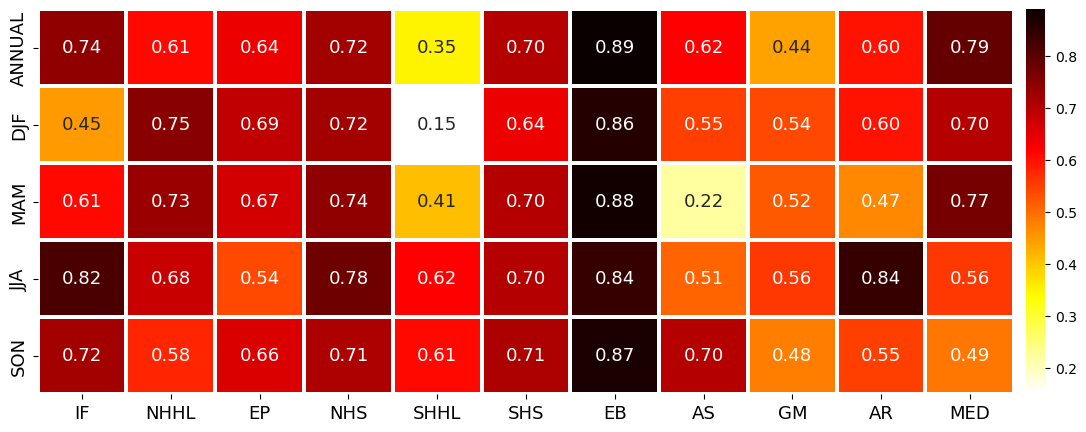

In [74]:
varname   = 'tos'
maskname  = 'biomes_regs'                        #'ipcc_regs'
gcms      = ['CNRM-CM6-1','CNRM-CM6-1-HR']

regions = mask_files_hires[maskname][2]

# Calculate correlation coefficients for each region and save
path2out = f'{root}/data/data_txt/high_res/spatial/correlation/'
if not os.path.exists(path2out):
            os.makedirs(path2out)
        
if os.path.isfile(f'{path2out}/pcorrelation_{ssp}_{maskname}.csv'):
    pcorr_all  = read_data(f'{path2out}/pcorrelation_{ssp}_{maskname}.csv',len(seasons))  
else:
    pcorr_all  = np.empty((len(regions),len(seasons)),dtype=float)
    for r in np.arange(len(regions)):
        region=regions[r]
        print(f'Working on the region {region}...')
        pcorr_all[r,:] = plot_regional_delta(
            path2data, varname,
            region, gcms,
            maskname=maskname,
            save_fig=False)
        plt.close()     
    np.savetxt(f'{path2out}/pcorrelation_{ssp}_{maskname}_regs.csv',  pcorr_all,  delimiter =" ",fmt='%6.2f')

# Read list regions to be processed
regions_list = f'{path2info}/{maskname}_names.txt'     #biomes_regs.txt'
regions  = read_txt(regions_list, 2, 'string')
reg_names=np.append(regions, 'World', axis=None)
nregions = len(reg_names)

# Plot heatmap
fig, ax = plt.subplots(figsize=(15,5))            # Sample figsize in inches
data = np.transpose(pcorr_all)
plot = sns.heatmap(data, linewidth=1.5, cmap='hot_r', 
                 annot=True, fmt=".2f", 
                 yticklabels=seasons, xticklabels=regions, 
                 annot_kws={"fontsize": 13},
                 cbar_kws={"pad":0.01},
                 ax=ax)
plot.tick_params(axis='both', which='major', labelsize=13)

# Save figure
plt.savefig(f'{path2figs}/Fig_7_{maskname}.pdf', bbox_inches='tight')
plt.savefig(f'{path2figs}/Fig_7_{maskname}.png', bbox_inches='tight', dpi=300)
plt.show()

### Figure 08: MED

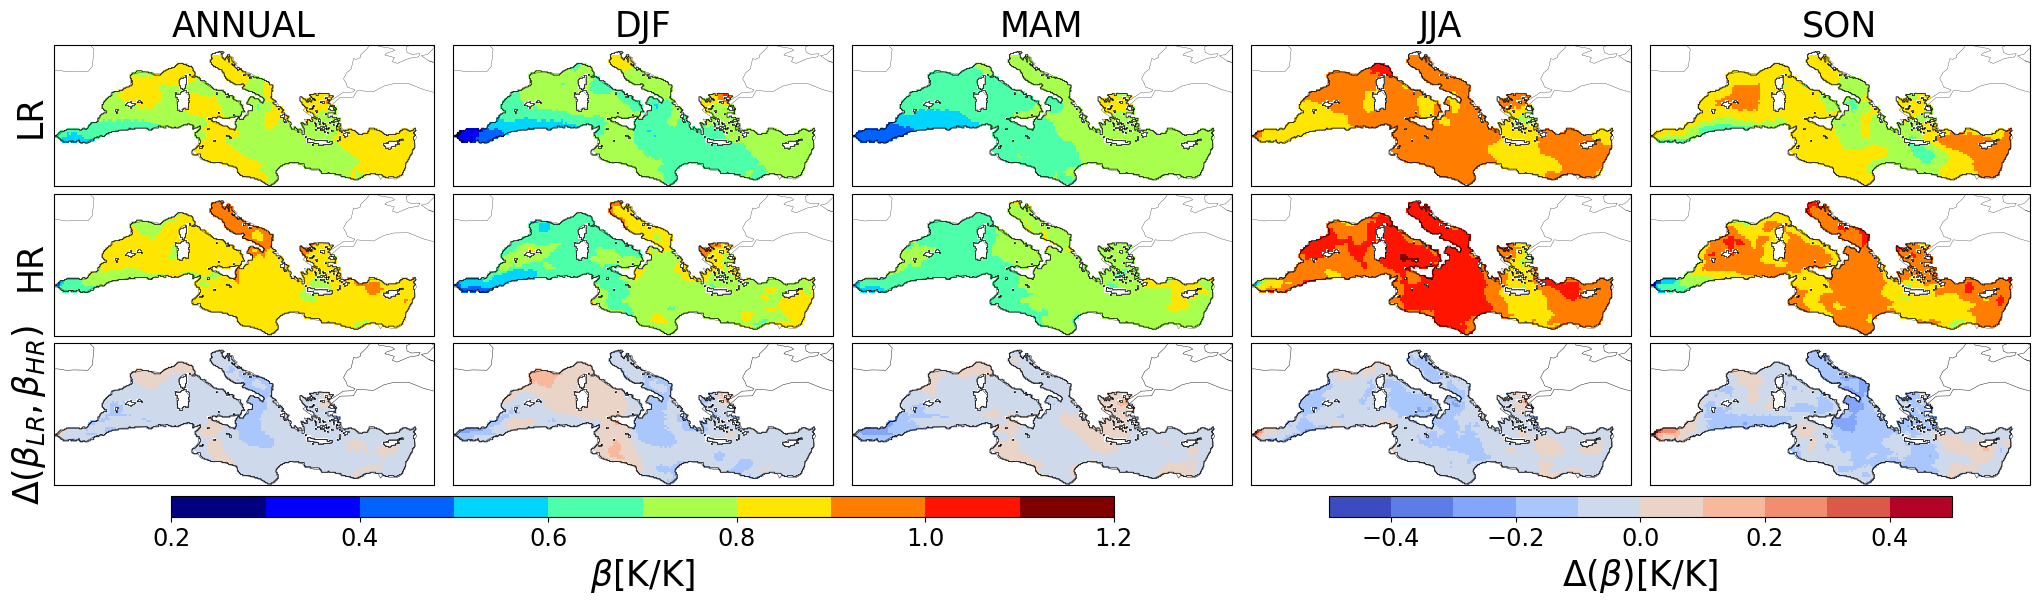

In [75]:
regions = [10]
for r in regions:
    plot_regional_delta(
        path2data,
        'tos', r, ['CNRM-CM6-1','CNRM-CM6-1-HR'] , 
        maskname='biomes_regs',
        fig_xsize=5.1,  
        fig_ysize=2.3,  
        vmin= 0.2, vmax = 1.2, dmax = 0.5,
        figname=f'Fig_8', save_fig=True)

### Figure 09: NAO

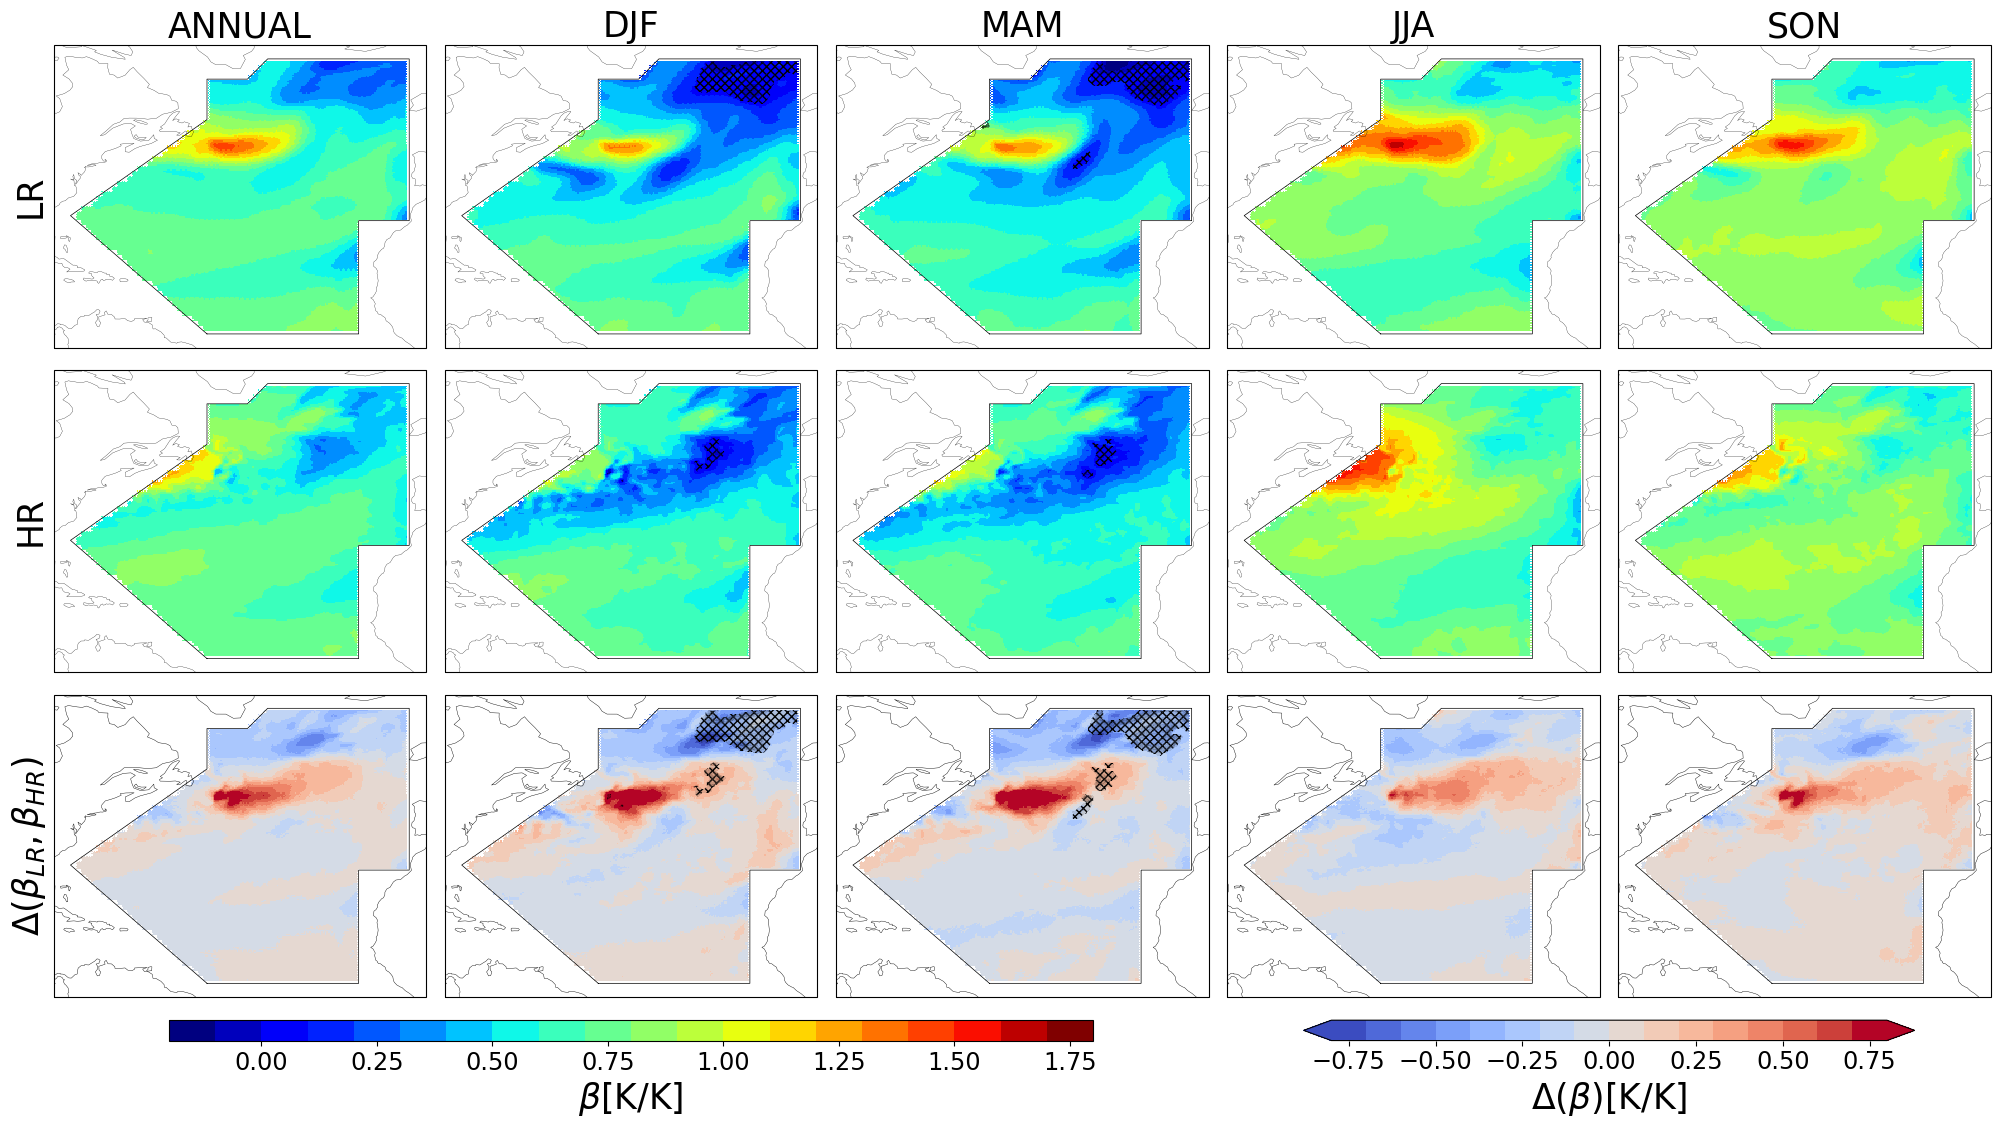

In [76]:
regions = [51]
for r in regions:
        plot_regional_delta(path2data,
                            varname, r, gcms, 
                            maskname='ipcc_regs',
                            fig_xsize=5., 
                            fig_ysize=5.,  
                            vmin= -0.2, vmax = 1.8, dmax = 0.8,
                            figname='Fig_9', save_fig=True)    

### Figure 14: SAO

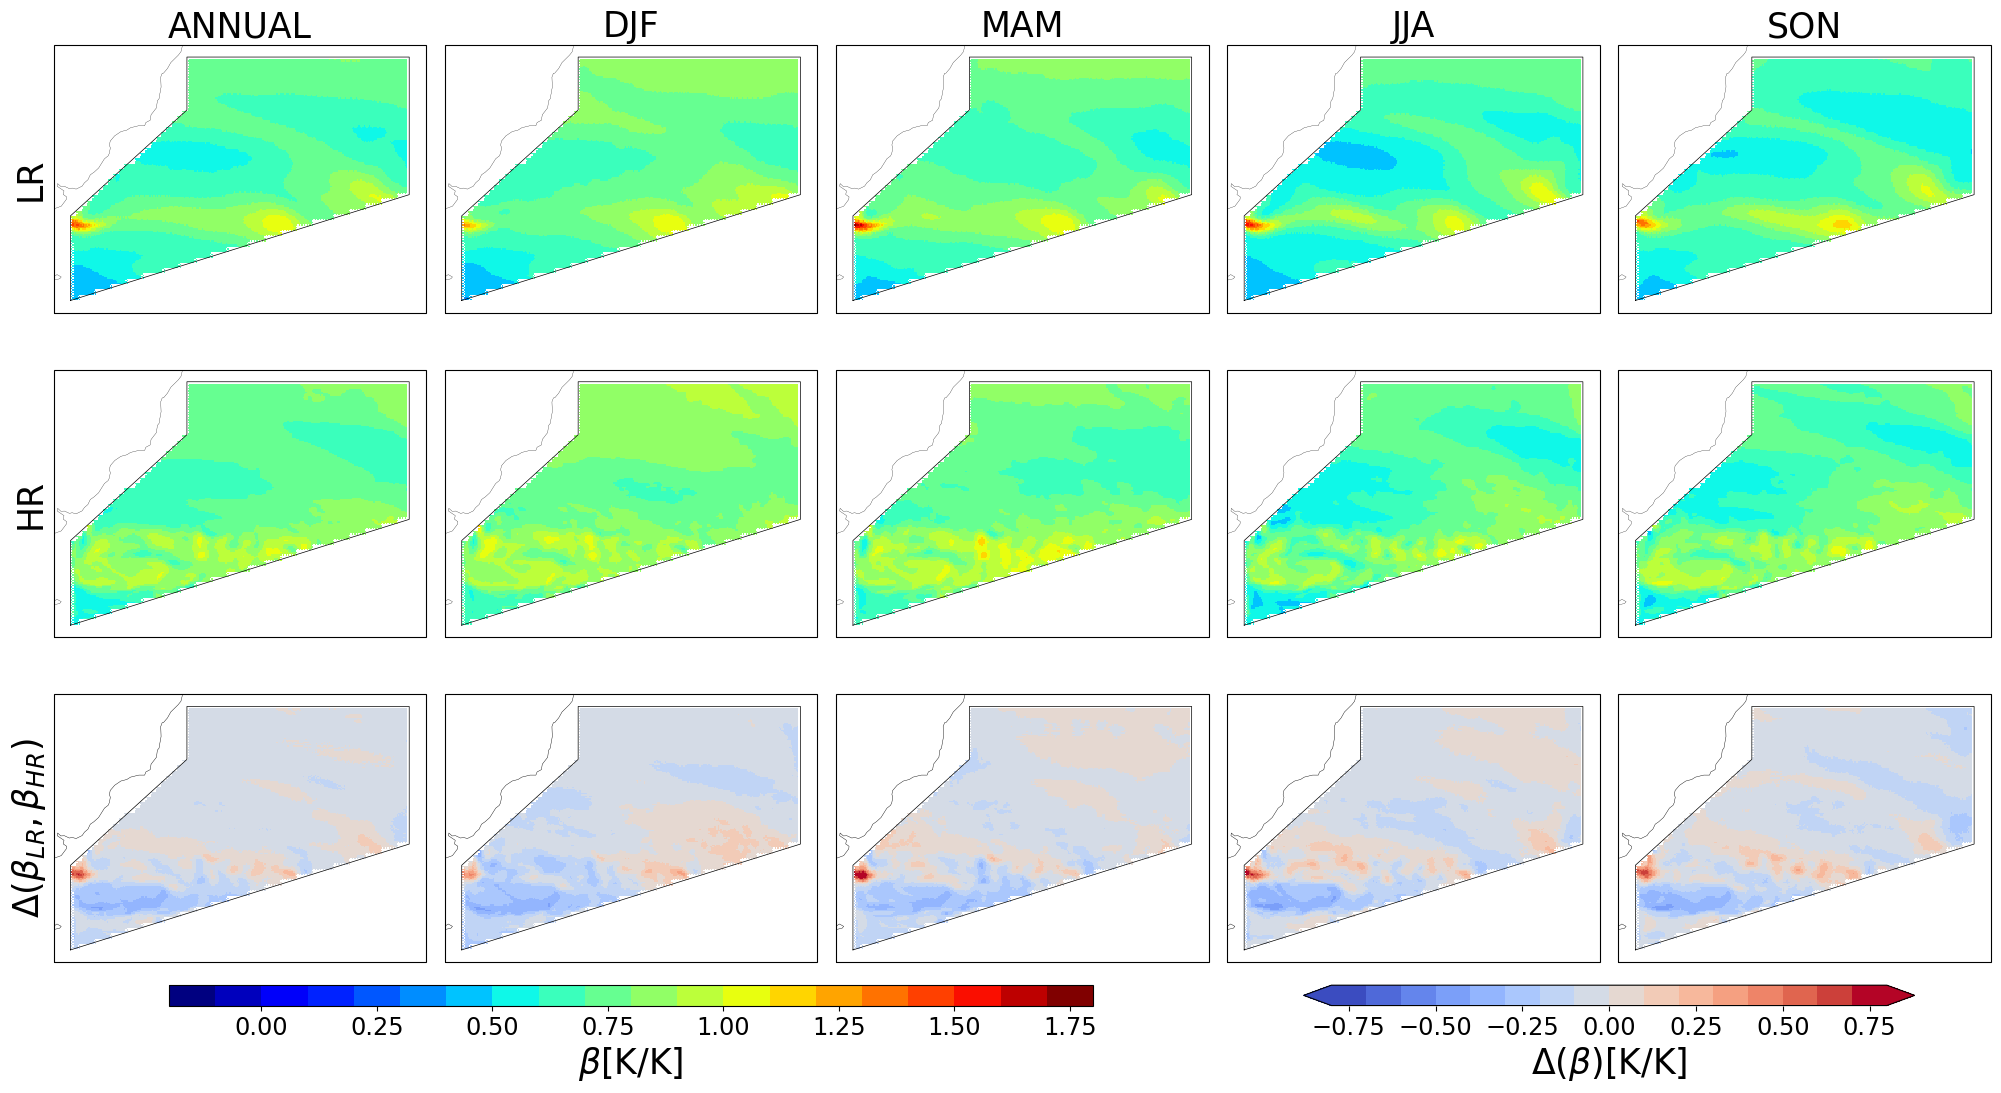

In [77]:
regions = [53]
for r in regions:
        plot_regional_delta(path2data,
                            varname, r, gcms, 
                            maskname='ipcc_regs',
                            fig_xsize=5, #figsizes[f'{9}'][0], 
                            fig_ysize=5, #figsizes[f'{9}'][1], 
                            vmin= -0.2, vmax = 1.8, dmax = 0.8,
                            figname='Fig_14', save_fig=True)  

# Figures 10 and 11: GWL plots for all IPCC regions

In [78]:
def plot_regional_delta(path2data, varname, maskname='ipcc_regs', ssp='ssp585', season='ANNUAL', figname="Fig", save_fig=True):
    
    mask_values = mask_files[maskname][2]
    dirname     = mask_files[maskname][3]
    
    nregions    = len(mask_values)
    
    regions_list = f'{path2info}/{dirname}_names.txt' #biomes_regs.txt'
    reg_names  = read_txt(regions_list, 2, 'string')
    nregions = len(reg_names)
    
    print(f'Working on the season: {season}')

    dirpath  = f'{resolution}/regional/{dirname}/{varname}/{season}'

    Beta = np.empty((nregions),dtype=float)
    R2_lin = np.empty((nregions),dtype=float)
    R2_exp = np.empty((nregions),dtype=float)
    p_value = np.empty((nregions),dtype=float)
    std_value = np.empty((nregions),dtype=float)

    # Read reference data
    ref_fname = f'{path2data}/{resolution}/global/tas/tas_{ssp}_ANNUAL.csv'
    ref_data = read_data(ref_fname, nmembers)

    # Define size of the panel plot
    nx=int(np.ceil(nregions/3))
    ny=3
    fig, axs = plt.subplots(nx,ny,figsize=(16,12))
    plt.subplots_adjust(hspace = 0.16, wspace = 0.08)

    for r in np.arange(nregions):
        region=mask_values[r]
        reg_name=reg_names[r]  

        if r < nx:
            j=0
            i=r-nx*(j)
        elif nx <= r < 2*nx:
            j=1
            i=r-nx*(j)
        elif nx <= r < 3*nx:
            j=2
            i=r-nx*(j)

        filename = f'{varname}_{ssp}_reg{region}_{season}'
        fname = f'{path2data}/{dirpath}/{filename}.csv'
        robust_name = f'{path2data}/{dirpath}/ifrobust_{filename}.csv'

        data = read_data(fname, nmembers)
        robustness = read_data(robust_name, 1)

        plot_timesteps   = np.arange(ystart, data.shape[0], avg_period)
        ensemble_refmean = np.empty([len(plot_timesteps)])
        ensemble_mean    = np.empty([len(plot_timesteps)])           

        colors = cm.get_cmap('viridis_r', data.shape[0]-ystart) 

        for l in np.arange(ystart, data.shape[0], avg_period):

            label=str(int(1950+l)) + "-" + str(int(1950+l+avg_period-1))

            # Define x and y tickmark boundaries

            xmin, ymin = 0, 0                
            if reg_name == 'ARO': 
                ymin=-1                
            elif np.floor(np.min(data[ystart:,:])) < 0:
                ymin=np.floor(np.min(data[ystart:,:]))

            if np.floor(np.min(ref_data[ystart:,:])) < 0:
                xmin=np.floor(np.min(ref_data[ystart:,:]))

            xmin, xmax = -0.5, 8
            ymin, ymax = -0.5, 8
            labelcolor = 'black'
            if reg_name == 'ARO' and varname == 'stas':
                ymax = 30
                labelcolor = 'red'
                axs[i,j].tick_params(axis='y', colors='red')                            

            if reg_name == 'MED' and varname == 'stas':
                ymax = 15

            # Set x and y tickmark boundaries
            axs[i,j].set_xlim([xmin, xmax])
            axs[i,j].set_ylim([ymin, ymax])

            # Plot data vs. gwl
            axs[i,j].plot(ref_data[l,:], data[l,:], 
                          'o', 
                          color=colors(l-ystart),
                          markeredgewidth=0,
                          label=label, 
                          alpha=0.7)          

            # Calculate ensemble mean
            index = int((l-ystart)/avg_period)
            ensemble_refmean[index] = np.mean(ref_data[l,:])
            ensemble_mean[index]    = np.mean(data[l,:])  

        # Calculate and plot linear fit                   
        x = ref_data[ystart::,:].reshape(-1, 1)
        y = data[ystart::,:].reshape(-1, 1)
        Beta[r], intercept, rvalue, p_value[r], std_value[r] = stats.linregress(x[:,0], y[:,0])
        R2_lin[r] = rvalue*rvalue #lm.score(x, y)
        lm = linear_model.LinearRegression()
        model = lm.fit(x, y) 
        axs[i,j].plot(x, model.predict(x), '-', color="black", label="Lin. fit", linewidth = 1)

        # Calculate and plot exponential fit
        def func(x, a, b): return a * np.exp(b * x)
        popt, pcov = curve_fit(func, x[:,0], y[:,0]) # a = popt[0], b = popt[1]
        x_fitted = np.linspace(np.min(x[:]), np.max(x[:]), 100)
        y_fitted = func(x_fitted, *popt) #a * np.exp(b * x_fitted)
        axs[i,j].plot(x_fitted, y_fitted, '--', color="black", label="Exp. fit ($a^{bx}$)", linewidth = 1)

        # Calculate R2 for the exponential fit
        residuals = y[:,0] - func(x[:,0], *popt)
        res = np.sum(residuals**2)
        tot = np.sum((y[:,0]-np.mean(y[:,0]))**2)
        R2_exp[r] = 1 - (res / tot)

        # Add refernece line
        axs[i,j].axline((0, 0), (1, 1), color='grey', linewidth = 0.5, label="Reference")

        # Add region names and statistical info on the plot                
        axs[i,j].annotate(reg_name, xy=(1, 0), xycoords='axes fraction', fontsize=13, color='k', fontweight = 'bold', 
                         horizontalalignment='right', verticalalignment='bottom')
        
        # Add names and statistical info on the plot                
        stat_info='$\\beta=$ %4.2f$\pm$%5.3f K/K \n$R^2_{lin}=$ %4.2f \n$R^2_{exp}=$ %4.2f' % (Beta[r], std_value[r], R2_lin[r], R2_exp[r])
        axs[i,j].annotate(stat_info, xy=(0.028, 0.95), xycoords='axes fraction', fontsize=9, color='k',
                          horizontalalignment='left', verticalalignment='top',
                          bbox={'facecolor': 'w', 'edgecolor': 'w','alpha': 0.5, 'pad': 3})

        # Add ensemble mean to the plot            
        for l in np.arange(ystart, data.shape[0], avg_period):
            index = int((l-ystart)/avg_period)    
            if float(robustness[l]) == 1.:
                axs[i,j].scatter(ensemble_refmean[index], ensemble_mean[index], 
                                 s=40, marker='s', #linewidth=1,
                                 facecolor="red", edgecolor="none",
                                 hatch='',zorder=10)
            elif float(robustness[l]) == 0.:
                axs[i,j].scatter(ensemble_refmean[index], ensemble_mean[index], 
                                 s=40, marker='s', #linewidth=2,
                                 facecolor="none", edgecolor="black",
                                 hatch=3*'//',zorder=10)                
            else:
                axs[i,j].scatter(ensemble_refmean[index], ensemble_mean[index], 
                                 s=40, marker='s', #linewidth=2,
                                 facecolor="none", edgecolor="black",
                                 hatch=6*'x',zorder=10) 
        # Add x and y axis title   
        if i==nx-1:
            axs[i,j].set_xlabel('GWL [K]')
        if j==0:
            if varname == 'tos':
                axs[i,j].set_ylabel('$\\Delta$ SST [K]')
            else:
                axs[i,j].set_ylabel('$\\Delta$ SSAT [K]')

        # Add gidlines
        axs[i,j].grid(color='grey', linestyle='--', linewidth=0.3)

    # Remove the created frames since there is no data
    ndelete=nx*ny-nregions
    for l in np.linspace(1,ndelete,ndelete):
        axs[nx-int(l),2].set_axis_off()
        axs[nx-int(l)-1,2].set_xlabel('GWL [K]')

    # Get Lines and lables for the legend       
    h, l = axs[i,j].get_legend_handles_labels()
    handles = h+[plt.plot([],marker="",  ls="")[0]] 
    handles = handles+[plt.plot([],marker="",  ls="")[0]]
    handles.append(mpatches.Patch(facecolor='red', edgecolor='red'))
    handles.append(mpatches.Patch(facecolor='None', edgecolor='black', hatch=3*'//'))
    handles.append(mpatches.Patch(facecolor='None', edgecolor='black', hatch=3*'x'))
    labels = l +  ["", "Ens. mean:", "Robust", "Not robust", "Conflicting"]

    # Add legend
    axs[i,j].legend(handles, labels, 
                    fontsize='medium', loc="lower center", 
                    bbox_to_anchor=(-0.58, -1.1), 
                    ncol=4,
                    handleheight=1.5, labelspacing=0.04, 
                    title_fontsize = 12) 

    # Save figure as pdf file                  
    plt.savefig(f'{path2figs}/{figname}_{varname}_{dirname}_{ssp}_{season}.pdf', bbox_inches='tight')
    plt.savefig(f'{path2figs}/{figname}_{varname}_{dirname}_{ssp}_{season}.png', bbox_inches='tight')
    plt.show()

Working on the season: ANNUAL


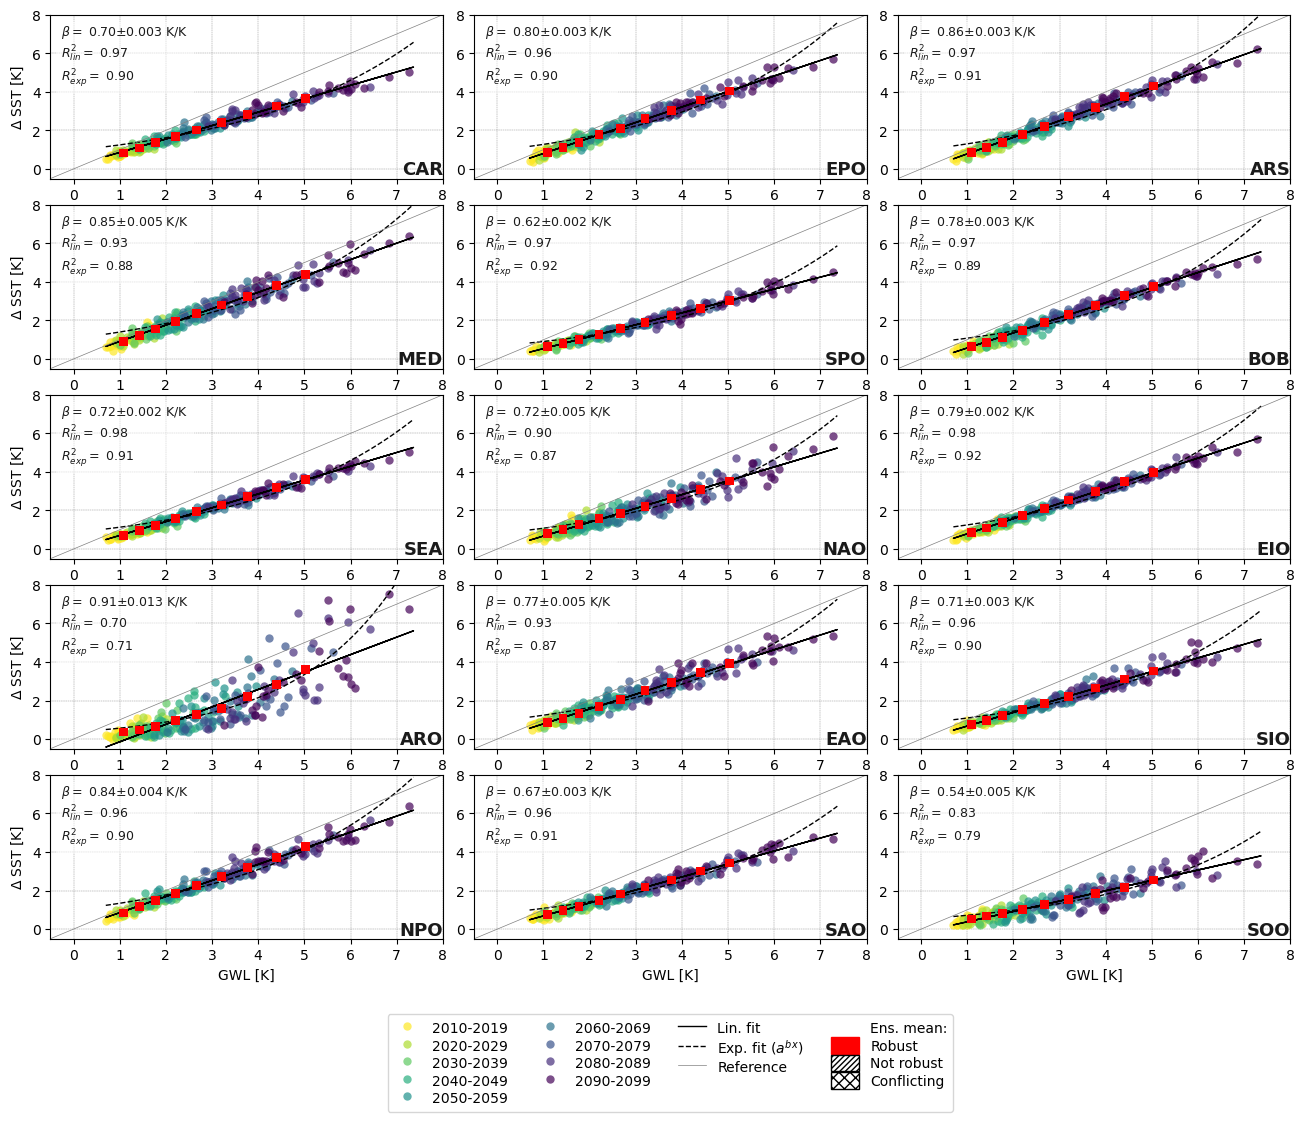

In [79]:
plot_regional_delta(path2data, 'tos', maskname='ipcc_regs', figname='Fig_10', season='ANNUAL', save_fig=True)

Working on the season: ANNUAL


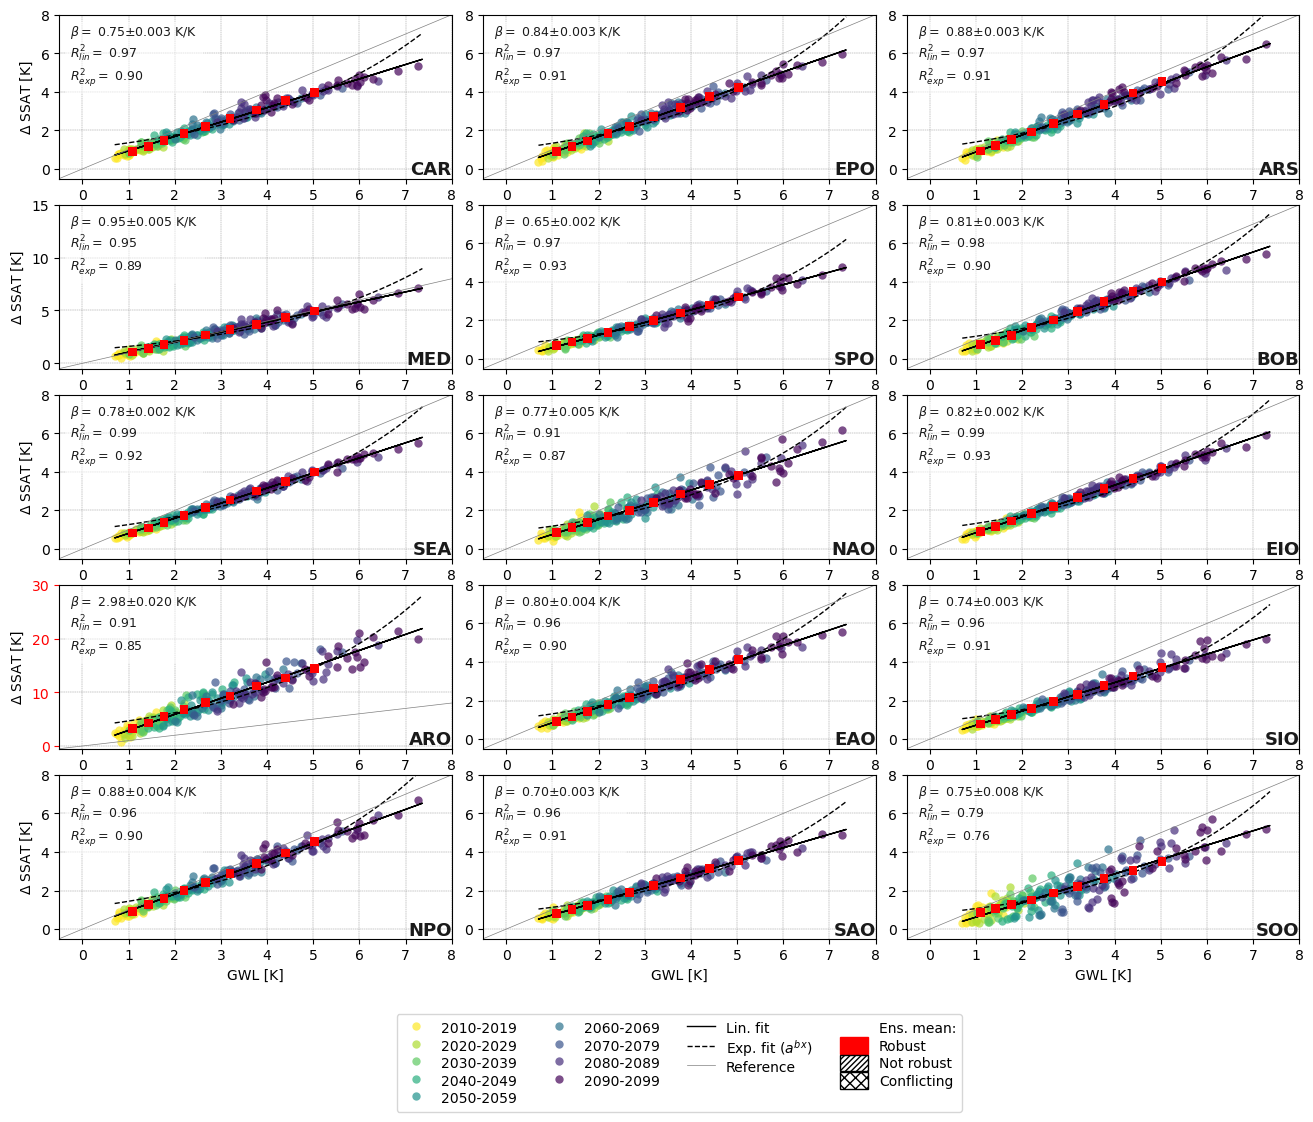

In [80]:
plot_regional_delta(path2data, 'stas', maskname='ipcc_regs', figname='Fig_11', season='ANNUAL', save_fig=True)

# Figures 12 and 13: Heat maps of beta slope per region - per ssp (stas & tos)

In [81]:
def triangled_heat_map(path2data, varname, stat_var, resolution='low_res', regions='ipcc_regs', figname='SP3'):
    # Read list of  to be processed
    regions_list = f'{path2info}/{regions}_names.txt'
    reg_short    = read_txt(regions_list, 2, 'string')
    reg_names    = np.append(reg_short, 'World', axis=None)
    nregions     = len(reg_names)

    masked_data=np.empty((nseasons, nregions-1, nssps),dtype=float)
    global_data=np.empty((nseasons, 1, nssps),dtype=float)

    for i, season in zip(np.arange(nseasons), seasons):
        path2regional=f'{path2data}/{resolution}/regional/{regions}/{varname}/{season}'
        masked_data[i] = read_data(f'{path2regional}/{stat_var}_{varname}_{season}.csv', nssps)    

        path2global=f'{path2data}/{resolution}/global/{varname}/'
        global_data[i] = read_data(f'{path2global}/{stat_var}_{varname}_{season}.csv', 1)

    data=np.append(masked_data, global_data, axis=1)
    data_2D_T = np.transpose(np.reshape(data, (nseasons*nregions, nssps)))

    M, N = nregions, nseasons
    vmin = 0.35
    vmax = 1.35
    values   = data_2D_T
    triangul = triangulation_for_triheatmap(M, N)
    cmaps = ['Reds', 'Reds', 'Reds', 'Reds']
    fig, ax = plt.subplots(figsize=(16,12))
    imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, ec='white', vmin=vmin, vmax=vmax, lw=1)
            for t, val, cmap in zip(triangul, values, cmaps)]

    for val, dir in zip(values, [(-1, 0), (0, 1), (1, 0), (0, -1)]):
        for i in range(M):
            for j in range(N):
                v=val[i + j*M]
                ax.text(i + 0.3 * dir[1], j + 0.3 * dir[0],
                        f'{v:.2f}', color='k' if v < 1.0 else 'w', 
                        fontsize=10, ha='center', va='center')

    ax.set_xticks(range(M))
    ax.xaxis.tick_top()
    ax.set_xticklabels(reg_names, fontsize=15)
    ax.set_yticks(range(N))
    ax.invert_yaxis()
    ax.set_yticklabels(season_names, fontsize=15)
    ax.margins(x=0, y=0)
    ax.set_aspect('equal', 'box')  # square cells

    if np.nanmax(values) > vmax: arr='max'
    elif np.nanmin(values) < vmin: arr='min'
    elif np.nanmin(values) < vmin and np.nanmax(values) > vmax: arr='both'
    else: arr='neither'

    cbar = fig.colorbar(imgs[0], ax=ax, shrink=0.7, pad=0.015, extend=arr, aspect=40,  orientation="horizontal")
    cbar.set_label(f'$\\beta$ [K/K]', rotation=0, labelpad=5, fontsize=20)
    cbar.ax.tick_params(labelsize=18)

    plt.tight_layout()
    plt.savefig(f'{path2figs}/{figname}_heatmap_{varname}.pdf', bbox_inches='tight')
    plt.savefig(f'{path2figs}/{figname}_heatmap_{varname}.png', bbox_inches='tight')
    plt.show()

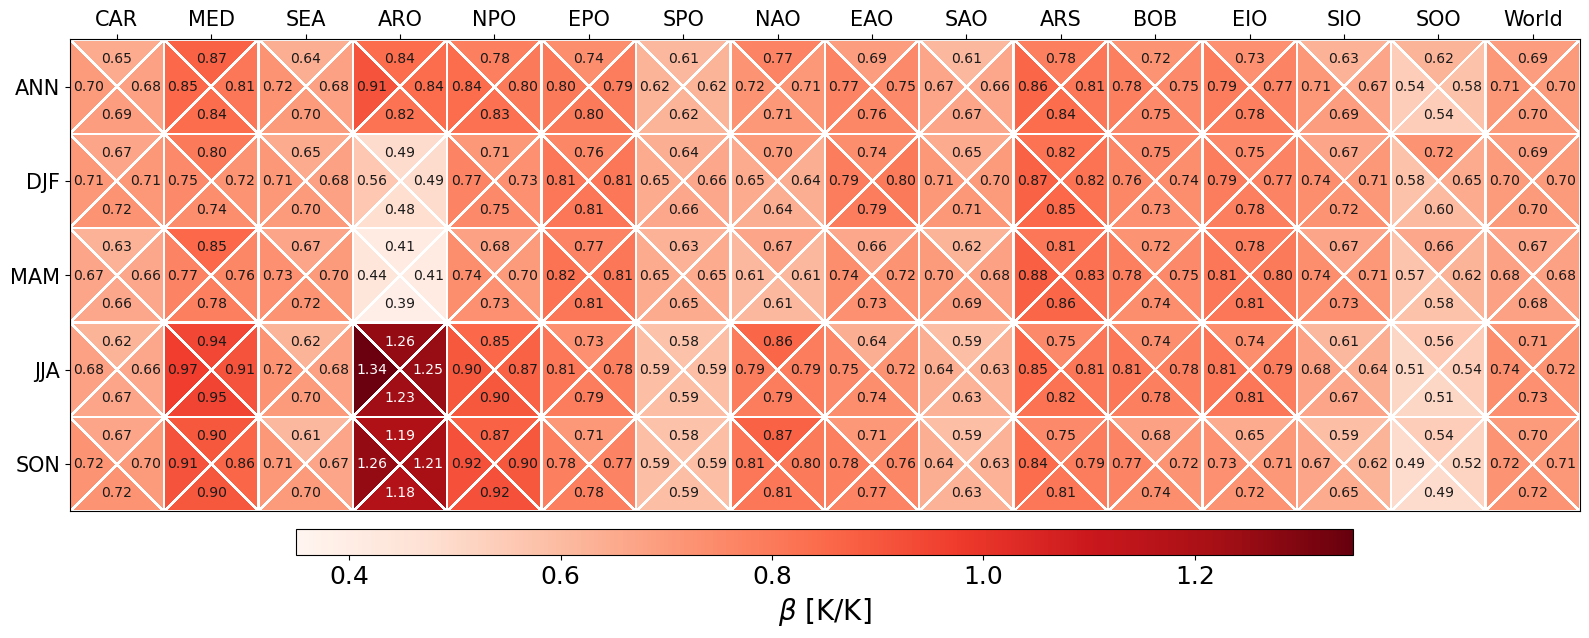

In [82]:
triangled_heat_map(path2data, 'tos', 'Beta', figname='Fig_12') # stat_var = Beta R2lin R2exp

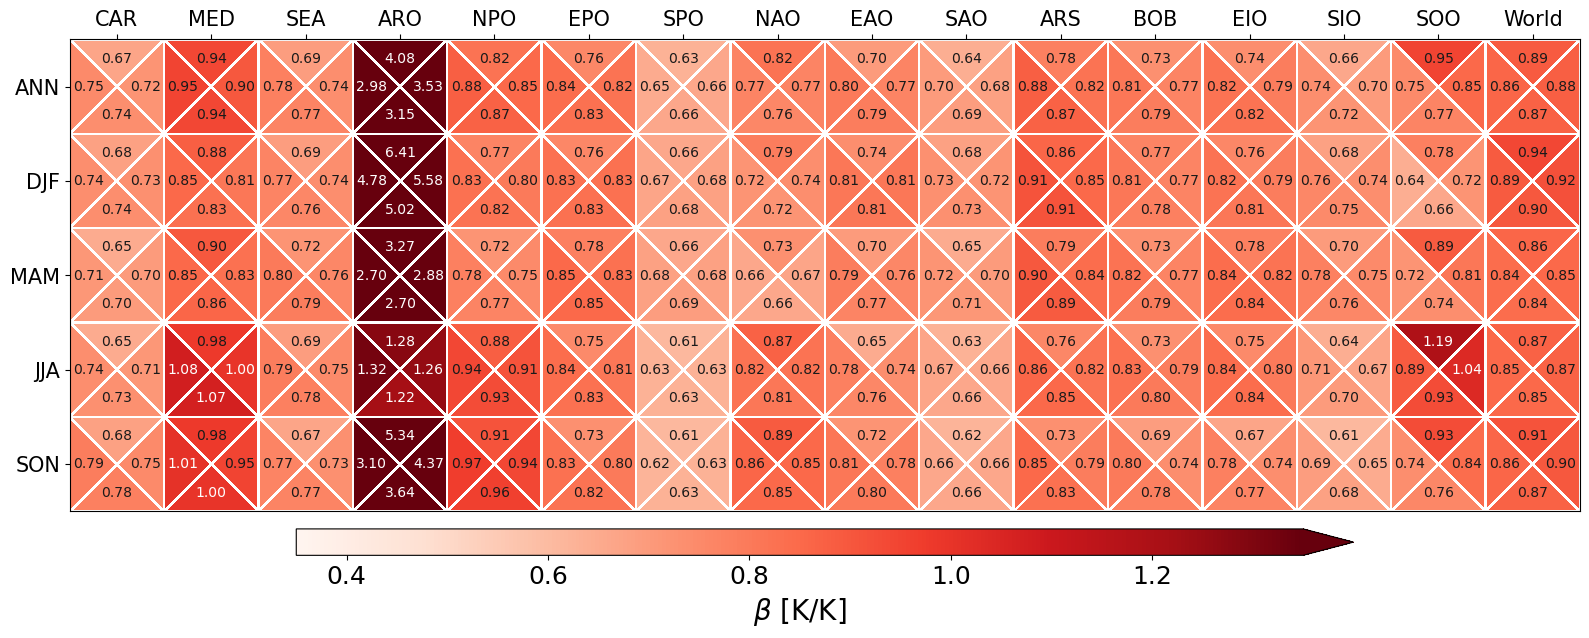

In [83]:
triangled_heat_map(path2data, 'stas', 'Beta', figname='Fig_13')

### Legend:

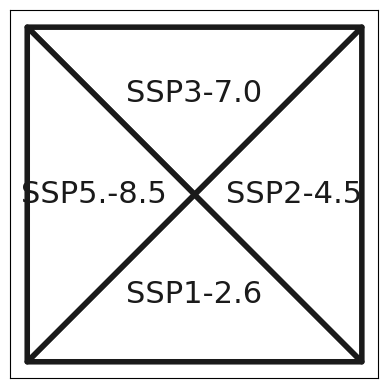

In [84]:
M,N = 1,1
values=np.zeros(4) #[[0],[0],[0],[0]]
ssps_names=['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5.-8.5']
cmap = mcolors.ListedColormap("w")
triangul = triangulation_for_triheatmap(M, N)
cmaps = [cmap,cmap,cmap,cmap]
fig, ax = plt.subplots(figsize=(4,4))
imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, ec='k', lw=4)
        for t, val, cmap in zip(triangul, values, cmaps)]

for val, dir in zip(ssps_names, [(-1, 0), (0, 1), (1, 0), (0, -1)]):
    for i in range(M):
        for j in range(N):
            ax.text(i + 0.3 * dir[1], j + 0.3 * dir[0], val, 
                    color='k', 
                    fontsize=22, ha='center', va='center')            
ax.set_aspect('equal', 'box')  # square cells
plt.xticks([])
plt.yticks([])
plt.savefig(f'{path2figs}/Fig12_13_legend.pdf', bbox_inches='tight')
plt.savefig(f'{path2figs}/Fig12_13_legend.png', bbox_inches='tight')

plt.tight_layout()
plt.show()